In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
sto_word = list(set(stopwords.words('english')))
from nltk.stem import WordNetLemmatizer  # lemmatizer

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

pd.set_option('mode.chained_assignment', None)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
import plotly.express as px

nltk.download('averaged_perceptron_tagger')
!pip install textblob
import string
punctuation = string.punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#<font color='red'>1.EDA</font>

## <font color='blue'>1.1 WHY COMBINE DATA AND THEN SPLIT</font>

In [ ]:
tr = pd.read_csv('/content/gdrive/MyDrive/cs1/data/train.csv')
tr.head()

Description  ...  Touching /Groping
0  Was walking along crowded street, holding mums...  ...                  1
1  This incident took place in the evening.I was ...  ...                  0
2  I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...  ...                  0
3                 Incident happened inside the train  ...                  0
4  I witnessed an incident when a chain was bruta...  ...                  0

[5 rows x 4 columns]

In [ ]:
tr.shape

(7201, 4)

In [ ]:
tr.drop_duplicates(inplace=True)
tr.shape

(6773, 4)

In [ ]:
xv = pd.read_csv('/content/gdrive/MyDrive/cs1/data/dev.csv')
xv.head()

Description  ...  Touching /Groping
0  Buses approaching to this place is highly unsafe.  ...                  1
1                        a man was commenting at me.  ...                  0
2                                    in a share auto  ...                  1
3  I was coming out of a club at night with a few...  ...                  0
4  One of my friends was molested in the crowd. T...  ...                  1

[5 rows x 4 columns]

In [ ]:
xv.shape

(990, 4)

In [ ]:
xv.drop_duplicates(inplace=True)
xv.shape

(962, 4)

In [ ]:
te = pd.read_csv('/content/gdrive/MyDrive/cs1/data/test.csv')
te.head()

Description  ...  Touching /Groping
0  During morning, a woman was walking by and thi...  ...                  0
1  A man tried to brush his penis off of a woman'...  ...                  1
2  This happened to a fellow passenger of mine tr...  ...                  0
3                                             ogling  ...                  0
4  When I was returning my home after finishing m...  ...                  1

[5 rows x 4 columns]

In [ ]:
te.shape

(1701, 4)

In [ ]:
te.drop_duplicates(inplace=True)
te.shape

(1640, 4)

In [ ]:
data_combine = pd.concat([tr,xv,te], ignore_index=True)
data_combine

Description  ...  Touching /Groping
0     Was walking along crowded street, holding mums...  ...                  1
1     This incident took place in the evening.I was ...  ...                  0
2     I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...  ...                  0
3                    Incident happened inside the train  ...                  0
4     I witnessed an incident when a chain was bruta...  ...                  0
...                                                 ...  ...                ...
9370                       obscene comments and staring  ...                  0
9371  I was going with my friend In metro in morning...  ...                  1
9372  A person tried to grab me when I was walkng in...  ...                  1
9373  few bad people touched my private parts in Ran...  ...                  1
9374  Age 16 yearsType of harassment Catcalls at Leh...  ...                  0

[9375 rows x 4 columns]

In [ ]:
data_combine.shape

(9375, 4)

In [ ]:
data_combine.drop_duplicates(inplace=True)
data_combine.shape

(9195, 4)

**REASON FOR COMBINING**

1. raw data has 9892 row(train, test, dev), since at later stage we will be doing cross validation to find robust results we require more data, so we combine all data and drop duplicate one, instead of droping duplicate individually and then combining as it leads to data leakage because some data points from train might present in test or dev or vice-versa. 

In [ ]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ["name", "original shape", "after drop duplicate shape", "total duplicate rows"]
pt.add_row(["train", (7201, 4), (6772,4), 428])
pt.add_row(["dev",   (990, 4),   (962,4), 28 ])
pt.add_row(["test",  (1701, 4), (1640,4), 61])
pt.add_row(['total', (9892,4), (9374,4), 517])
pt.add_row(['all combine', (9892,4), (9195,4), 697])  ##all combine than drop duplicates 
print(pt)

+-------------+----------------+----------------------------+----------------------+
|     name    | original shape | after drop duplicate shape | total duplicate rows |
+-------------+----------------+----------------------------+----------------------+
|    train    |   (7201, 4)    |         (6772, 4)          |         428          |
|     dev     |    (990, 4)    |          (962, 4)          |          28          |
|     test    |   (1701, 4)    |         (1640, 4)          |          61          |
|    total    |   (9892, 4)    |         (9374, 4)          |         517          |
| all combine |   (9892, 4)    |         (9195, 4)          |         697          |
+-------------+----------------+----------------------------+----------------------+


## <font color='blue'>1.2 EDA AFTER COMBINING DATA</font>

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/cs1/data/train.csv')
dev = pd.read_csv('/content/gdrive/MyDrive/cs1/data/dev.csv')
test = pd.read_csv('/content/gdrive/MyDrive/cs1/data/test.csv')

In [ ]:
def all_data(x,y,z):                 

  """takes 3 data arguments, train, dev, test
     combine and drop duplicate
     delete null value if any
     return combined data"""

  data = pd.concat([x,y,z], ignore_index=True)
  data.drop_duplicates(inplace=True)
  data.columns = map(str.lower, data.columns)
  data['description'] = data['description'].map(str.lower)
  data.rename(columns = {'ogling/facial expressions/staring' : 'ogling', 'touching /groping' : 'grouping'}, inplace = True)
  if data.isnull().values.any() == False:
    print(f'shape of combine data : {data.shape}')
  else:
    print(f'deleting nan values')
    data.dropna(axis = 1)
    print(f'shape of combine data : {data.shape}')

  return data

combined_data = all_data(train, dev, test)
combined_data.head()
#Ogling/Facial Expressions/Staring	Touching /Groping

shape of combine data : (9195, 4)


description  ...  grouping
0  was walking along crowded street, holding mums...  ...         1
1  this incident took place in the evening.i was ...  ...         0
2  i was waiting for the bus. a man came on a bik...  ...         0
3                 incident happened inside the train  ...         0
4  i witnessed an incident when a chain was bruta...  ...         0

[5 rows x 4 columns]

In [ ]:
pos_dic = {'noun' : ['NN','NNS','NNP','NNPS']}

def pos_chk(x,type):

  '''x : data,
     type : noun,
     return count of noun'''

  count = 0
  try:
    tb = TextBlob(x)
    for i in tb.tags:
      type_list = list(i)[1]
      if type_list in pos_dic[type]:
        count += 1
  except:
    pass
  return count

def noun_words(frame, column, type):

  '''frame : dataframe,
  column   : text column,
  type     : noun,
  return list of all noun in text data'''

  noun_list = []
  for i in frame[column]:
    tb = TextBlob(i)
    for j in tb.tags:
      #type_list = list(i)
      if j[1] in pos_dic[type]:
        noun_list.append(j[0])
  return noun_list

In [ ]:
combined_data['noun_count']            = combined_data['description'].apply(lambda x: pos_chk(x, 'noun'))
combined_data['punctuation_count']     = combined_data['description'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
combined_data['stopword_count']        = combined_data['description'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in sto_word]))

In [ ]:
combined_data.head()

description  ...  stopword_count
0  was walking along crowded street, holding mums...  ...              15
1  this incident took place in the evening.i was ...  ...               7
2  i was waiting for the bus. a man came on a bik...  ...               9
3                 incident happened inside the train  ...               1
4  i witnessed an incident when a chain was bruta...  ...               9

[5 rows x 7 columns]

In [ ]:
#NN: Noun, singular or mass, NNS: Noun, plural, NNP: Proper noun, singular Phrase, NNPS: Proper noun, plural

### <font color='green'>1.2.1 PREPROCESSING DATA</font>

In [ ]:
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    
    """performs common expansion of english words, preforms preprocessing"""

    text = re.sub(r"won\'t", "will not", text)   # decontracting the words
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r'\w+:\s?','',text)                                            ## removing anyword:
    text = re.sub('[([].*?[\)]', '', text)                                       ## removing sq bracket and its content
    text = re.sub('[<[].*?[\>]', '', text)                                       ## removing <> and its content
    text = re.sub('[{[].*?[\}]', '', text)                                       ## removing {} and its content
    
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])       ## lemmatizing the word

    text = re.sub(r'\W', ' ', str(text))                                         # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)                                  # remove all single characters 
    text = re.sub(r"[^A-Za-z0-9]", " ", text)                                    # replace all the words except "A-Za-z0-9" with space  
    text = re.sub(r'[^\w\s]','',text)
    text = ' '.join(e for e in text.split() if e.lower() not in set(stopwords.words('english')) and len(e)>2)  
    # convert to lower and remove stopwords discard words whose len < 2
    
    text = re.sub("\s\s+" , " ", text)                                           ## remove extra white space  lst
    text = text.lower().strip()   

    return text


In [ ]:
combined_data['description'] = combined_data['description'].map(lambda x : preprocess(x))

### <font color='green'>1.2.2 PLOTTING DATA FOR INSIGHTS</font>

#### <font color='brown'>1.2.2.1 COUNTING PROPORTION OF UNIQUE VALUE IN EACH LABEL</font>

In [ ]:
def plot_count_data(data):

  '''take data as input
  outputs each label with their repective counts of 0, 1'''

  targt = data.columns.tolist()[1:]
  for i,lab in enumerate(targt):             
    
    total = data.shape[0]

    fig = plt.figure()
    fig.patch.set_facecolor('silver')
    
    ax = sns.countplot(x=lab, data=data)
    #ax.set_title("count data")
    for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()+1.4), ha='center', va='top', color='white', size=18)
      percentage = '{:.1f}%'.format(100 * p.get_height()/total)
      ax.annotate(percentage, (p.get_x()+0.4, p.get_height()-1500), ha='center', size=18)

    print(f'\n{lab} ratio 0:1 equals {round(data[lab].value_counts()[0]/data[lab].value_counts()[1], 2)} : 1')
    
    plt.title(f'counting unique values in {lab} label')
    plt.ylabel('count in each unique values')
    plt.xlabel(f'{lab} label unique values')
    plt.show()


commenting ratio 0:1 equals 1.61 : 1


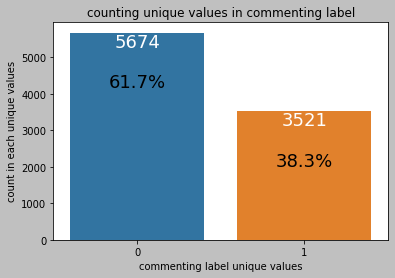


ogling ratio 0:1 equals 3.82 : 1


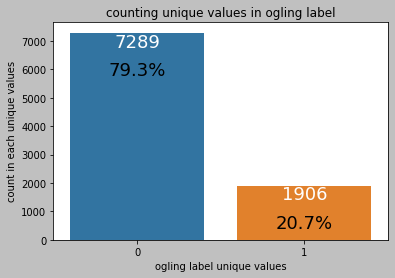


grouping ratio 0:1 equals 2.3 : 1


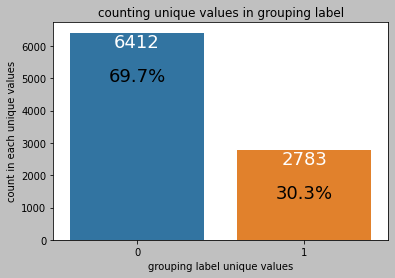


noun_count ratio 0:1 equals 0.27 : 1


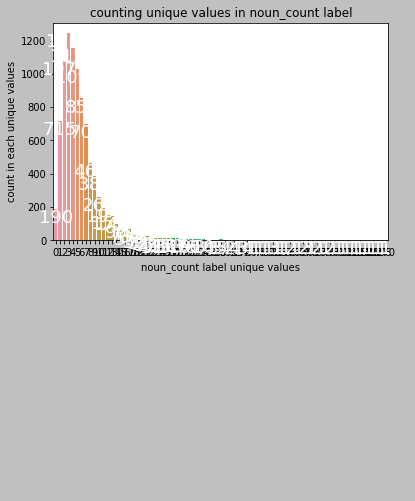


punctuation_count ratio 0:1 equals 1.03 : 1


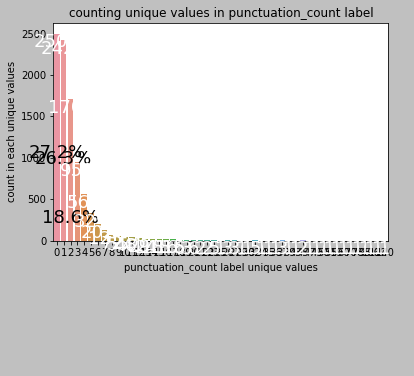


stopword_count ratio 0:1 equals 0.99 : 1


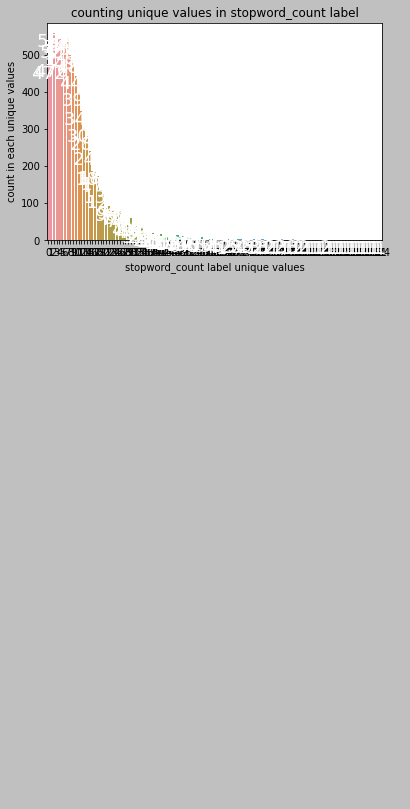

In [ ]:
plot_count_data(combined_data)

**OBSERVATION**

1. in commenting label 5674 have 0 label which compries of 61.7% of total data, and label 1 have 3521 data points which compries of 38.3% of total data.

2. commenting have ratio of 0:1 equals 1.61 : 1 (5674/3521) which we will be using in further case study.

3. in ogling label 7289 have 0 label which compries of 79.3% of total data, and label 1 have 1906 data points which compries of 20.7% of total data.

4. ogling have ratio of 0:1 equals 3.82 : 1 (7289/1906) which we will be using in further case study.

5. in grouping label 6412 have 0 label which compries of 69.7% of total data, and label 1 have 2783 data points which compries of 30.3% of total data.

6. grouping have ratio of 0:1 equals 2.3 : 1 (6412/2783) which we will be using in further case study.

#### <font color='brown'>1.2.2.2 COUNTING POSSIBLE SUM OF VALUES AND ITS PROPORTION ROW WISE</font>

In [ ]:
def row_label_count(frame, column_list, text):

  '''takes data as input
  calculates row wise label count
  returns frequency of items in labels row wise'''


  possible_label = {0:'zero', 1:'one', 2:'two', 3:'three'}
  dic = {}
  for i in range(0,4):
    p0 = ((frame[column_list]).sum(axis=1)).values
    count = (p0 == i).sum()
    dic[i] = count
  kd = dict((possible_label[key], value) for key,value in dic.items())

  total = frame[text].shape[0]

  fig = plt.figure(figsize=(8,5))
  fig.patch.set_facecolor('silver')
  
  ax = sns.barplot(x=list(kd.keys()), y=list(kd.values()))
  for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()+1.4), ha='center', va='top', color='white', size=14)
      percentage = '{:.1f}%'.format(100 * p.get_height()/total)
      ax.annotate(percentage, (p.get_x()+0.4, p.get_height()+10), ha='center',size=14)

  plt.title('count of data points in possible sum values in labels row wise')
  plt.xlabel('possible sum values')
  plt.ylabel('count of sum values')

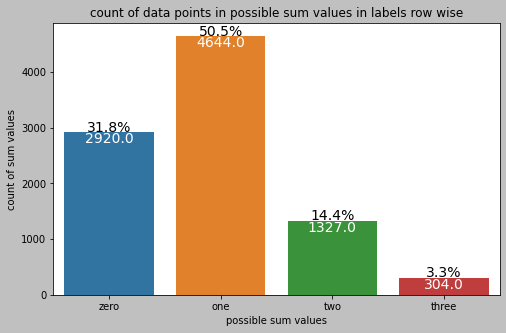

In [ ]:
row_label_count(combined_data, ['commenting', 'ogling', 'grouping'], 'description')

**OBSERVATION**

1. 4644 points which is roughly 50.5% of total data point, corresponds to any one of category which may be commenting or grouping or ogling.

2. 2920 points which is roughly 31.8% of total data point, have no labels which clearly depicts that the story does not correpond to any sexual harassment activity.

3. 1327 points which is roughly 14.4% of total data point, corresponds to any of two category which may be (commenting and grouping) or (commenting and ogling) or (ogling and grouping).

4. 304 points which is roughly 3.3% of total data point, corresponds to all the three category such as commenting, ogling and grouping.

#### <font color='brown'>1.2.2.3 COUNTING POSSIBLE SUM OF VALUES AND ITS PROPORTION COLUMN WISE</font>

In [ ]:
def zeros_ones(data):
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.patch.set_facecolor('silver')
  total = data.shape[0]
  ax = sns.barplot(x=data.columns[1:].values, y=data.iloc[:,1:].sum(axis=0).values) #column
  for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=18)
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    ax.annotate(percentage, (p.get_x()+0.4, p.get_height()-1500), ha='center', size=18)

  plt.title('plot between each label and their sum (column wise)')
  plt.xlabel('labels')
  plt.ylabel('count of values in each label')

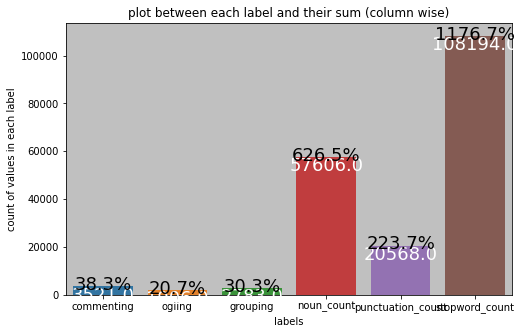

In [ ]:
zeros_ones(combined_data)

**OBSERVATION**

1. commenting bar have 3521 data points out of 9195 which means 38.3% of data in commenting have 1 and 61.7% are 0.

2. ogling bar have 1906 data points out of 9195 which means 20.7% of data in ogling have 1 and 79.3% are 0.

3. grouping bar have 2783 data points out of 9195 which means 30.3% of data in grouping have 1 and 69.7% are 0.



#### <font color='brown'>1.2.2.4 VIZUALIZATION OF FREQUENT AND RARE WORDS BASED ON IDF VALUES</font>

In [ ]:
def vizulaize_idf_rare_feq_word(frame, text, text_col, feat, i):   

  '''takes frame : dataframe, 
     text        : text column, 
     text_col    : target label,
     feature     : int(max. which we want to display)
              i  : ngram range
     returns : frequent, rare words based on idf value
  '''
 
  tfidf_vect = TfidfVectorizer(ngram_range=(i,i), stop_words=set(stopwords.words('english')))
  idf        = tfidf_vect.fit_transform(frame[text][frame[text_col]==1])
  feat_names = tfidf_vect.get_feature_names()
  idf_value  = tfidf_vect.idf_
  df         = pd.DataFrame(list(zip(feat_names, idf_value)), columns=['word','idf_value'])

  df.sort_values("idf_value", axis = 0, ascending = False, inplace = True, ignore_index=True) #0=row
  rare     = df['word'][:feat].tolist()
  rare_idf = df['idf_value'][:feat].tolist()

  
  fig = plt.figure(figsize=(12,12))
  fig.patch.set_facecolor('silver')

  plt.subplot(211)
  sns.barplot(y = rare, x = rare_idf)
  plt.title('rare word by idf value')
  plt.xlabel('idf_score')
  plt.ylabel('rare idf words')

  df.sort_values("idf_value", axis = 0, ascending = True, inplace = True, ignore_index=True)
  frequent         = df['word'][:feat].tolist()
  frequent_idf     = df['idf_value'][:feat].tolist()
  
  
  plt.subplot(212)
  sns.barplot(y = frequent, x = frequent_idf)
  plt.title('frequent word by idf value')
  plt.xlabel('idf_score')
  plt.ylabel('frequent idf words')

  plt.suptitle(f'{text_col} label')
plt.show()


##### 1.2.2.4.1 VISUALIZING COMMENTING, OGLING, GROUPING LABEL UNIGRAMS BASED ON IDF VALUES

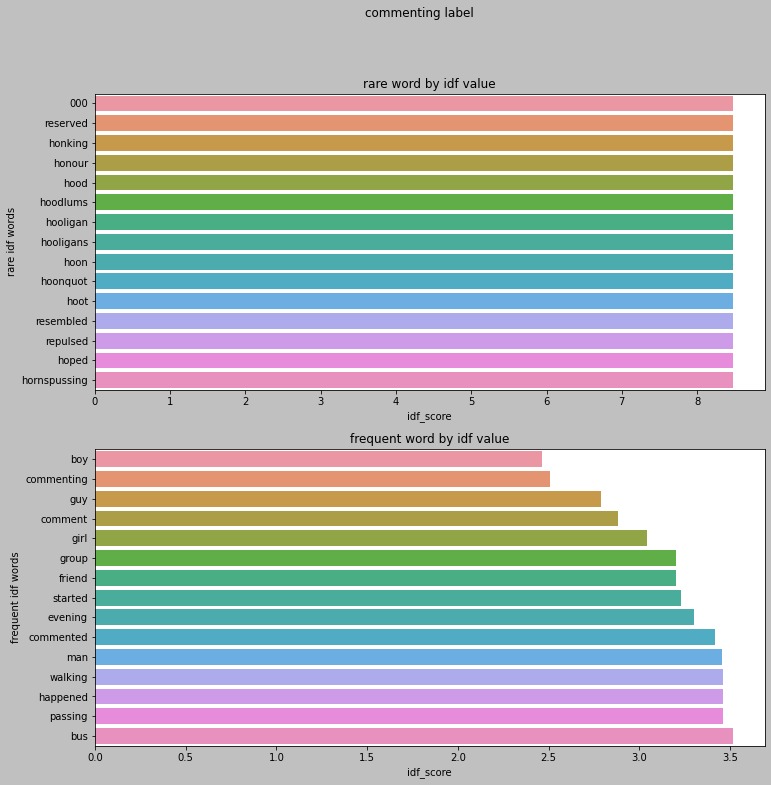

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'commenting', 15, 1)

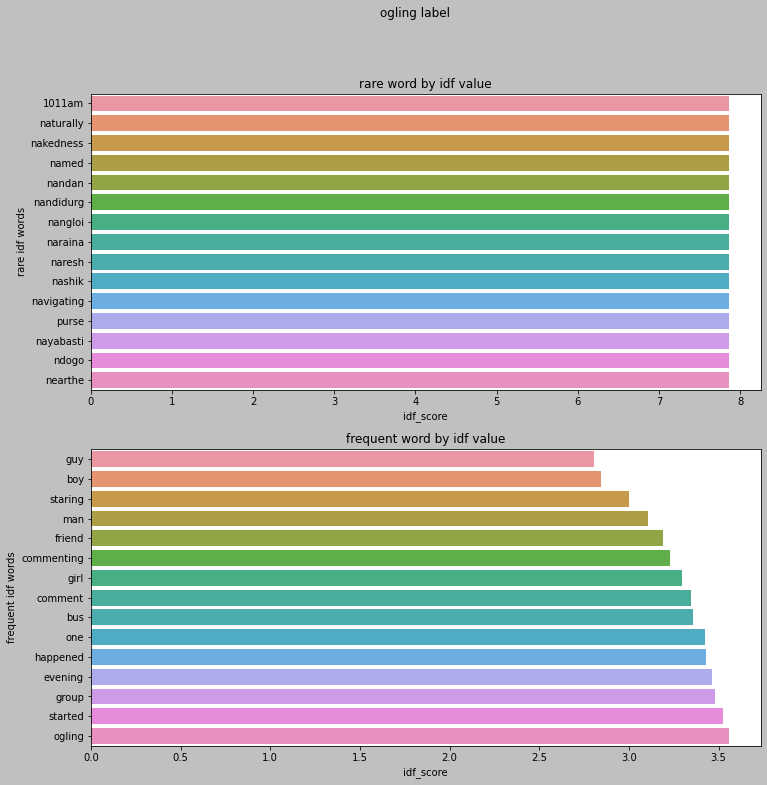

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'ogling', 15, 1)

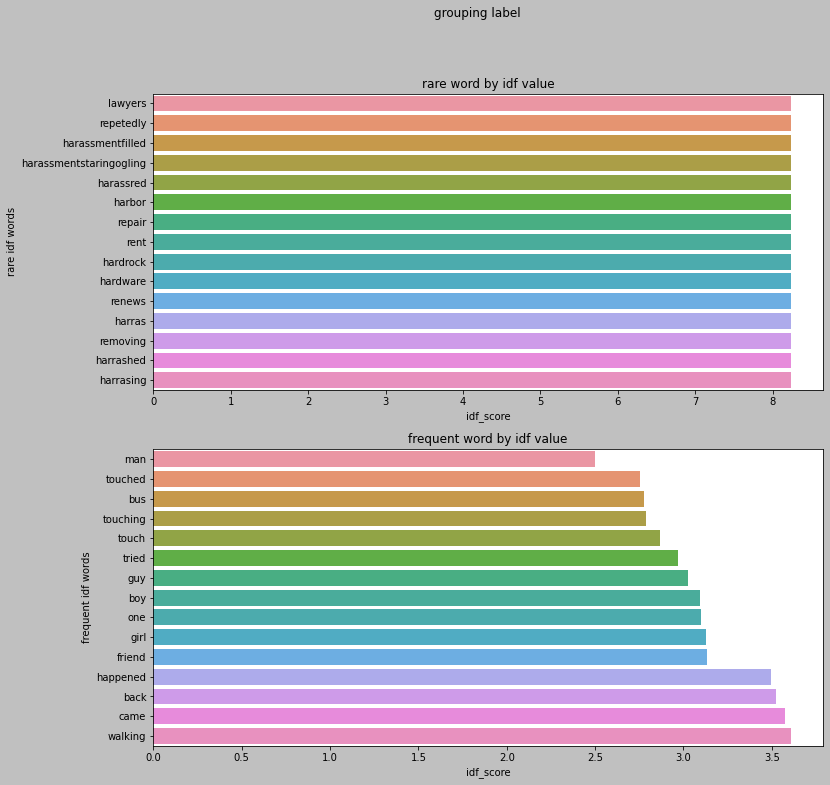

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'grouping', 15, 1)

##### 1.2.2.4.2 VISUALIZING COMMENTING, OGLING, GROUPING LABEL BIGRAMS BASED ON IDF VALUES

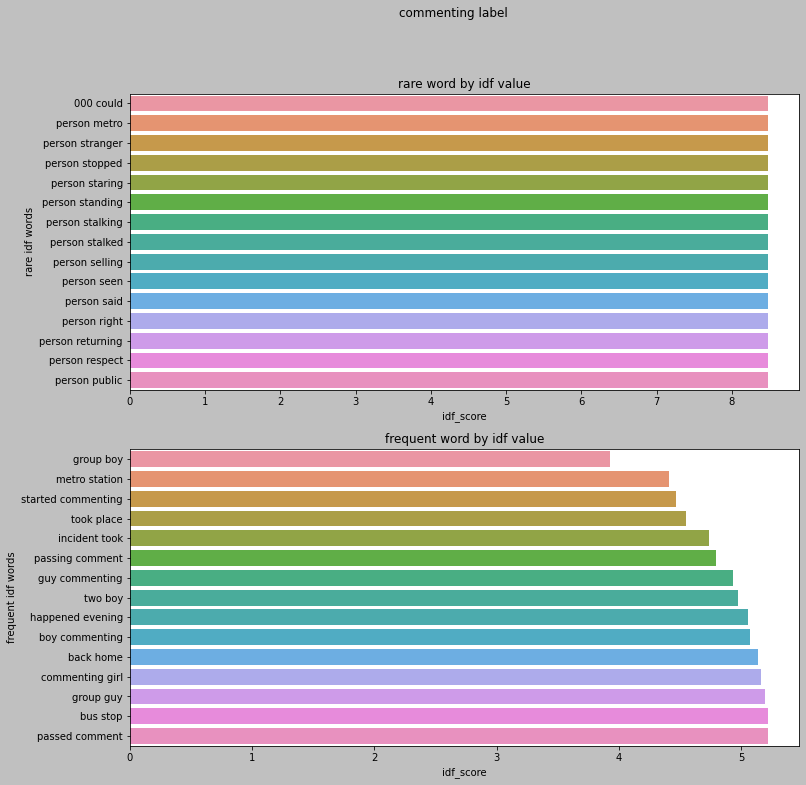

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'commenting', 15, 2)

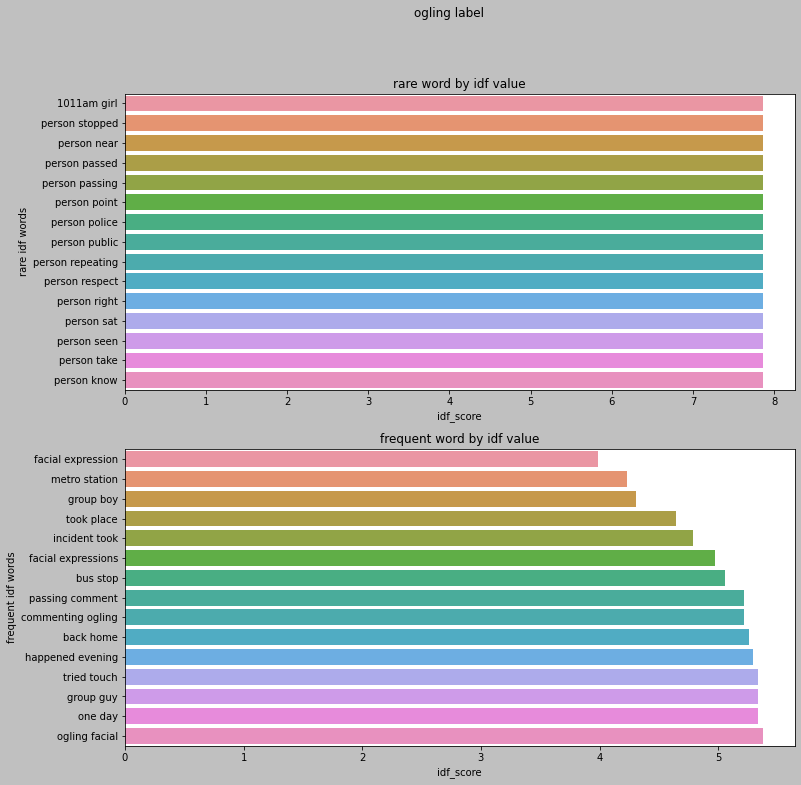

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'ogling', 15, 2)

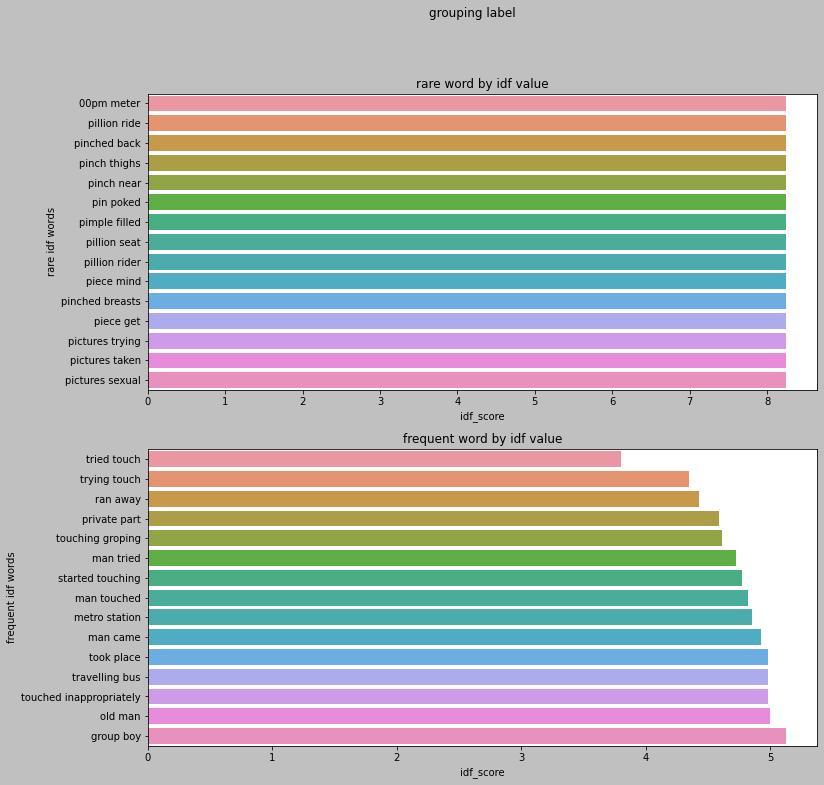

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'grouping', 15, 2)

##### 1.2.2.4.3 VISUALIZING COMMENTING, OGLING, GROUPING LABEL TRIGRAMS BASED ON IDF VALUES

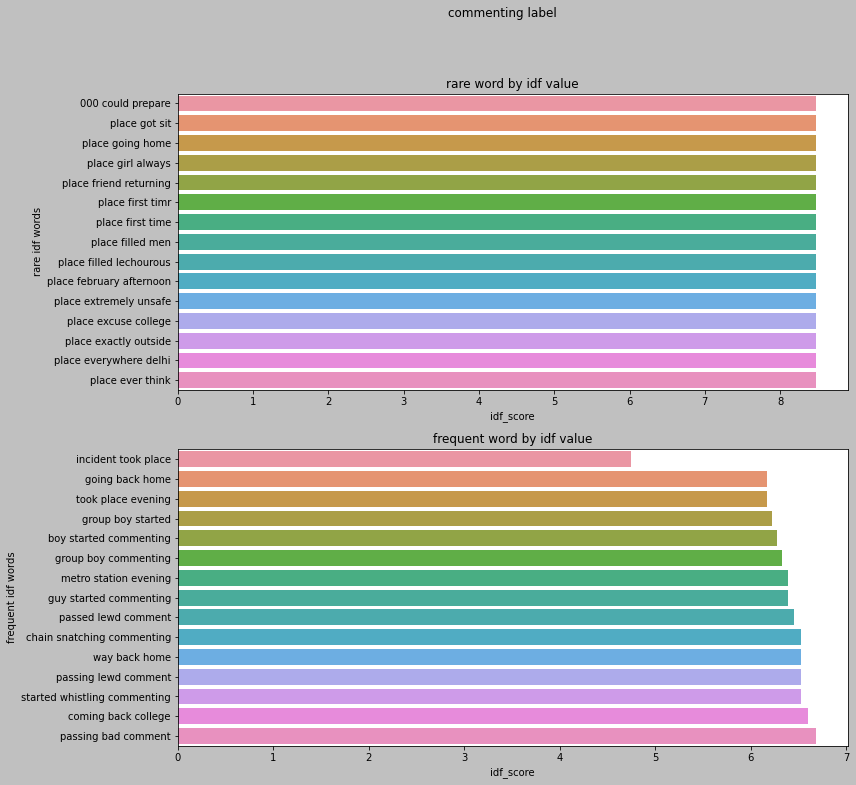

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'commenting', 15, 3)

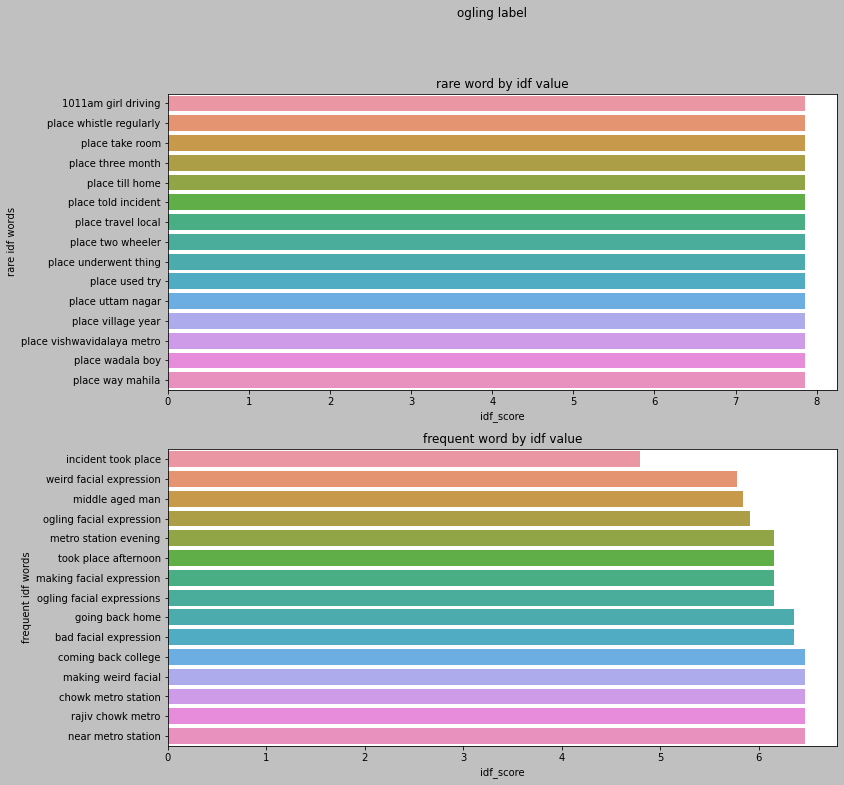

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'ogling', 15, 3)

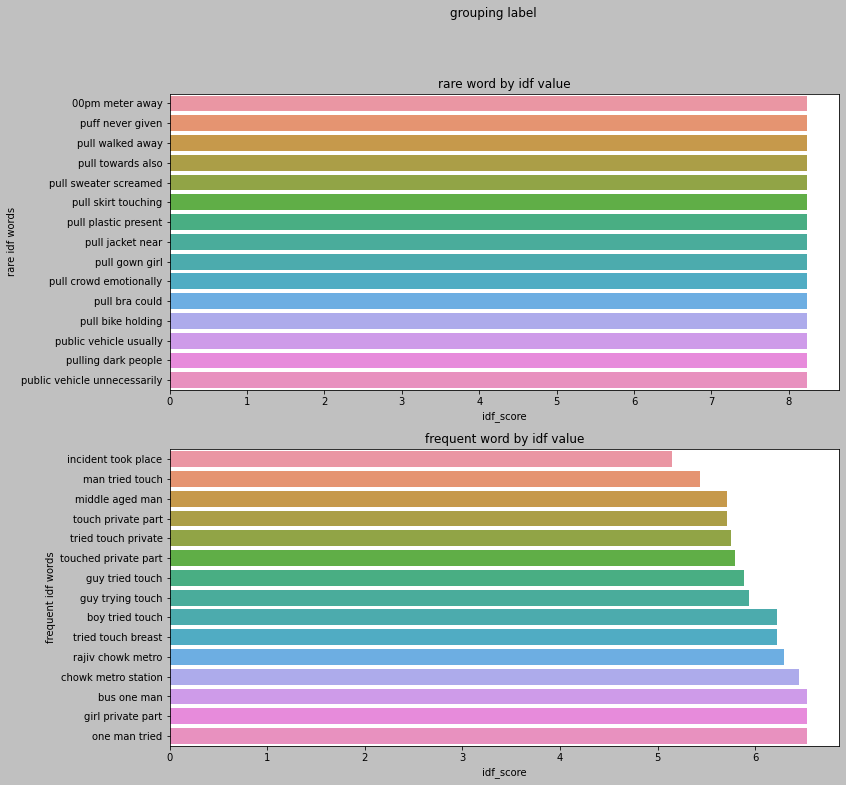

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'grouping', 15, 3)

##### 1.2.2.4.4 VISUALIZING COMMENTING, OGLING, GROUPING LABEL FOURGRAMS BASED ON IDF VALUES

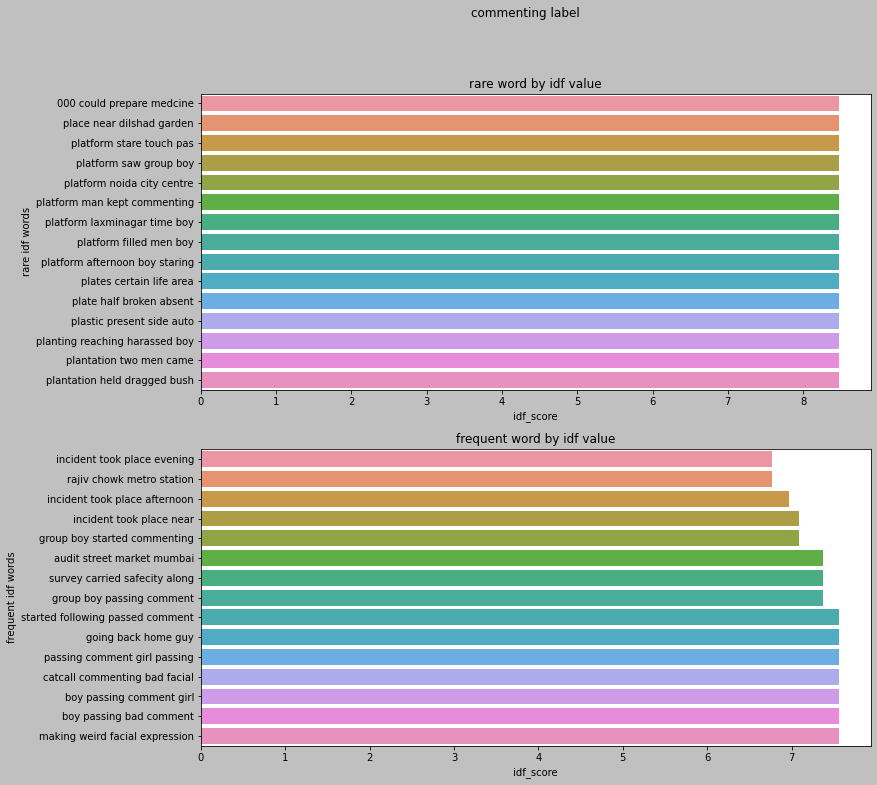

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'commenting', 15, 4)

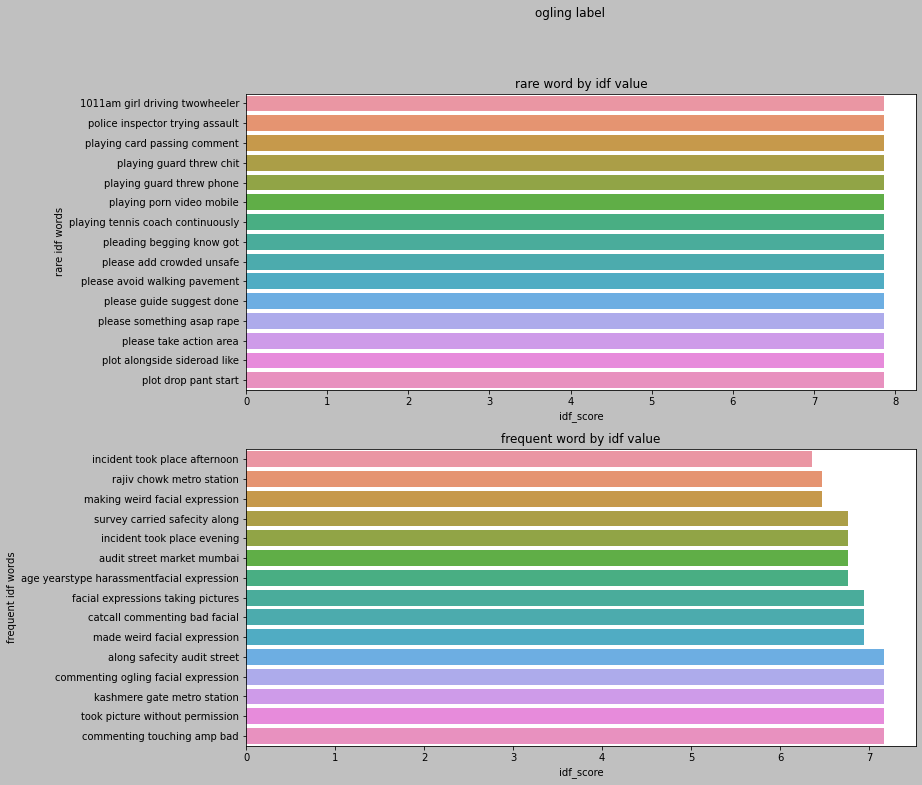

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'ogling', 15, 4)

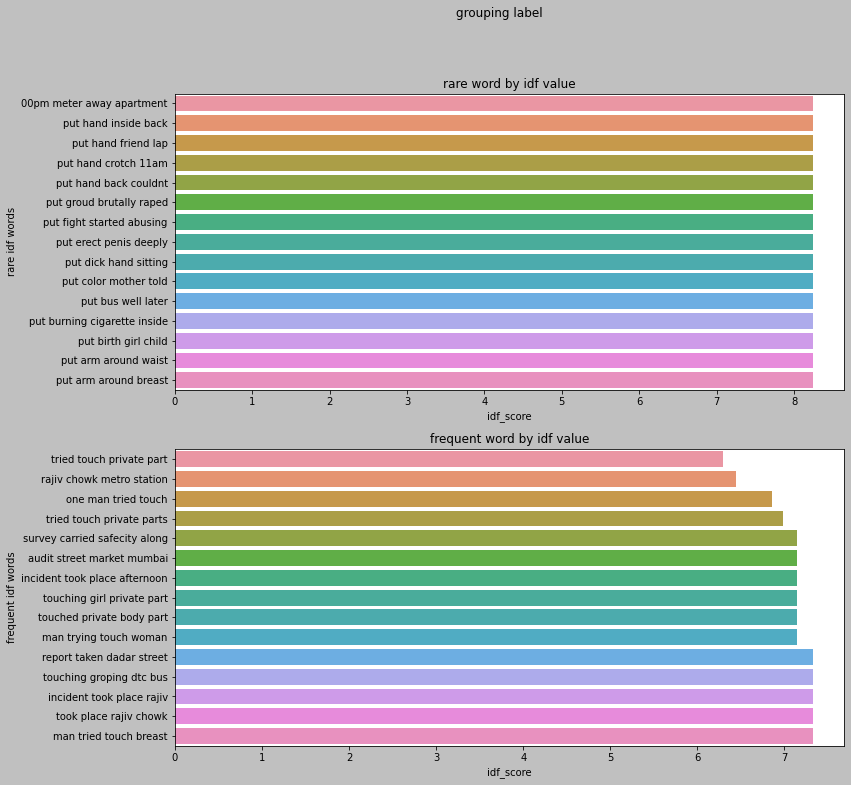

In [ ]:
vizulaize_idf_rare_feq_word(combined_data, 'description', 'grouping', 15, 4)

#### <font color='brown'>1.2.2.5 VIZUALIZATION OF FREQUENT AND RARE WORDS BASED ON COUNTVECTORIZER</font>

In [ ]:
def vizulaize_countvec_rare_feq_word(frame, text, text_col, feat, i, stop_word=True):   

  '''takes frame : dataframe, 
     text        : text column, 
     text_col    : target label,
     feature : int(max. which we want to display)
     returns : frequent, rare words based on idf value
  '''
  
  if stop_word == True:
    stop_word  = set(stopwords.words('english'))
    count_vect = CountVectorizer(ngram_range=(i,i), stop_words=stop_word)
  if stop_word == False:
    count_vect = CountVectorizer(ngram_range=(i,i), stop_words=None)

  cnt        = count_vect.fit_transform(frame[text][frame[text_col]==1])
  feat_names = count_vect.get_feature_names()
  count_value= cnt.toarray().sum(axis=0)
  df         = pd.DataFrame(list(zip(feat_names, count_value)), columns=['word','count'])

  df.sort_values("count", axis = 0, ascending = False, inplace = True, ignore_index=True) #0=row
  freq     = df['word'][:feat].tolist()
  freq_cnt = df['count'][:feat].tolist()

  
  #fig = plt.figure(figsize=(20,5))
  fig = plt.figure(figsize=(12,12))
  fig.patch.set_facecolor('silver')


  plt.subplot(211)
  sns.barplot(y = freq, x = freq_cnt)
  plt.title('freqent word by count value')
  plt.xlabel('count of words')
  plt.ylabel('freq words')

  df.sort_values("count", axis = 0, ascending = True, inplace = True, ignore_index=True)
  rare         = df['word'][:feat].tolist()
  rare_cnt     = df['count'][:feat].tolist()

  plt.subplot(212)
  sns.barplot(y = rare, x = rare_cnt)
  plt.title('rare word by count value')
  plt.xlabel('count of words')
  plt.ylabel('rare words')

  plt.suptitle(f'{text_col} label')
plt.show()



##### 1.2.2.5.1 VIZUALIZATION OF COMMENTING, OGLING, GROUPING LABEL UNIGRAM   BASED ON COUNTVECTORIZER WITH STOPWORDS

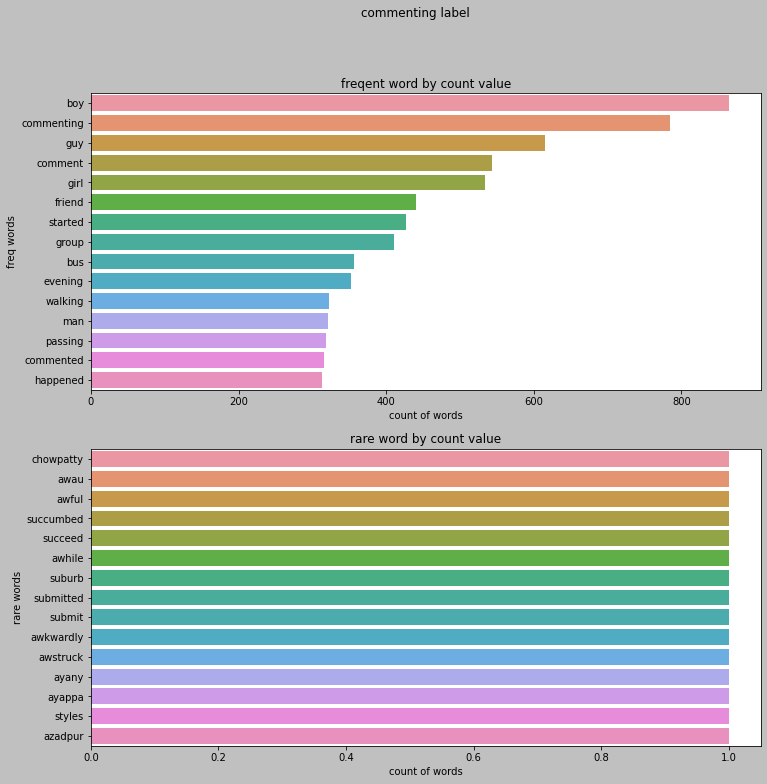

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'commenting', 15, 1, stop_word=True)

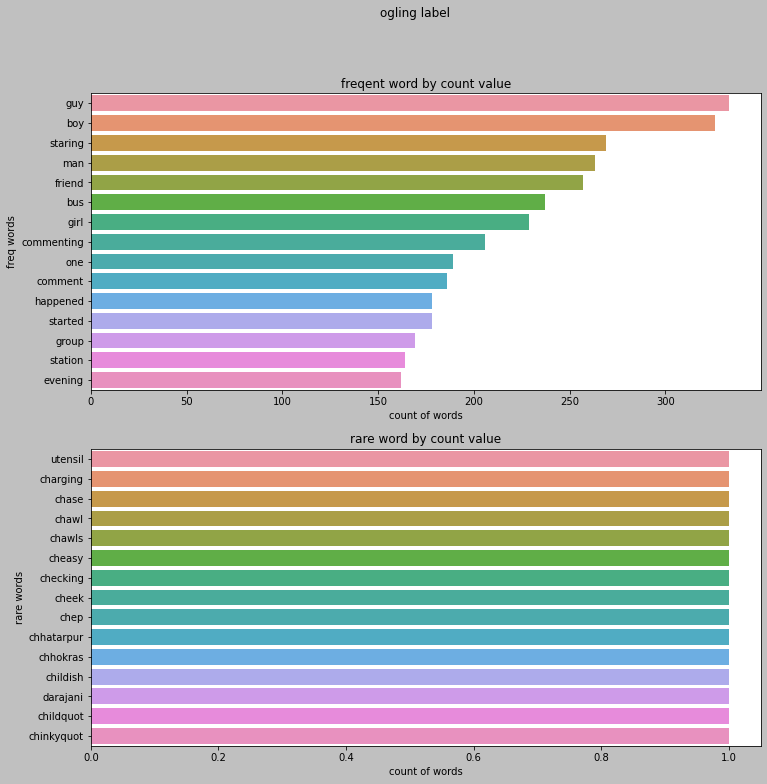

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'ogling', 15, 1, stop_word=True)

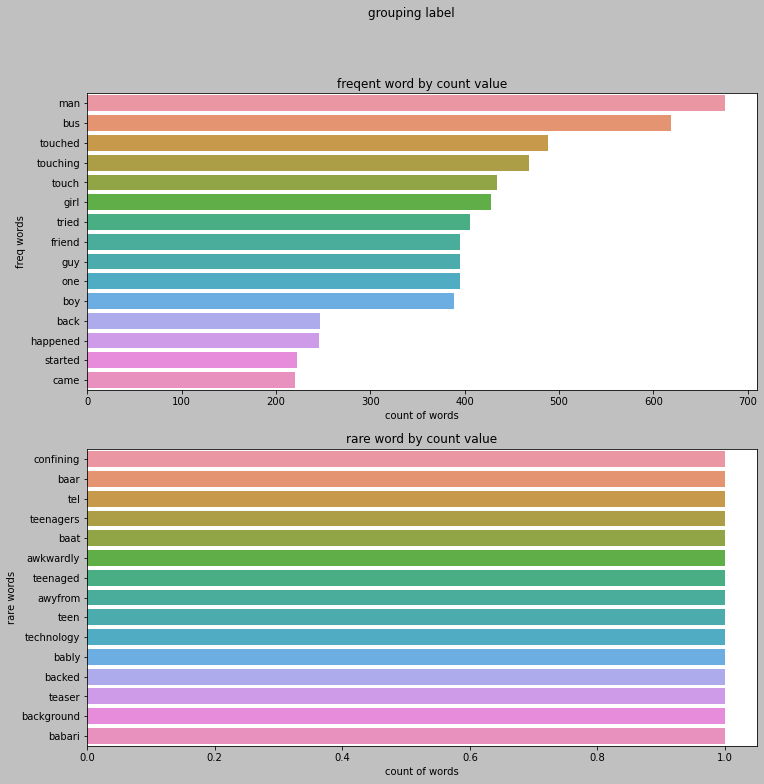

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'grouping', 15, 1, stop_word=True)

##### 1.2.2.5.2 VIZUALIZATION OF COMMENTING, OGLING, GROUPING LABEL UNIGRAM   BASED ON COUNTVECTORIZER WITHOUT STOPWORDS

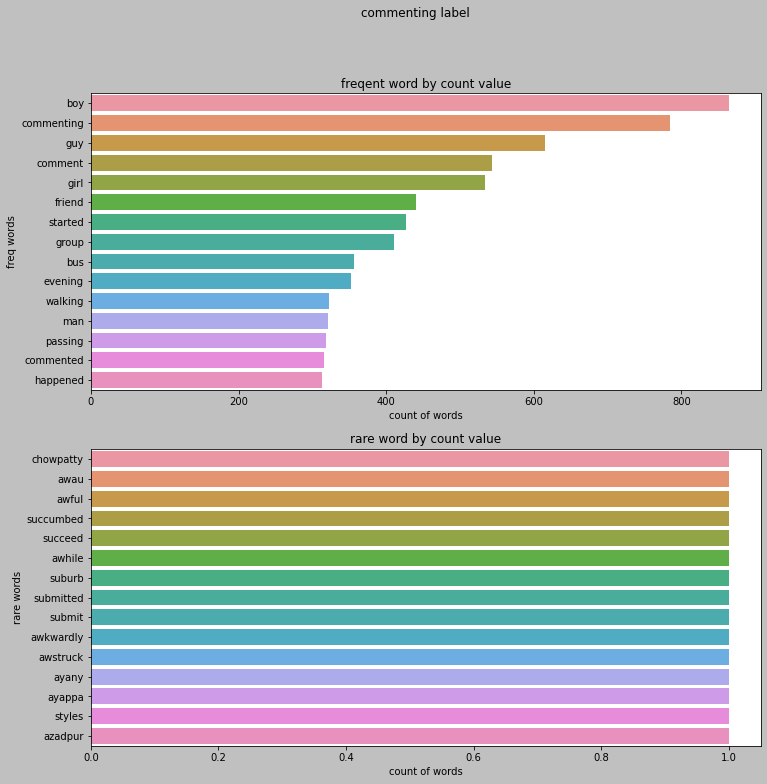

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'commenting', 15, 1, stop_word=False)

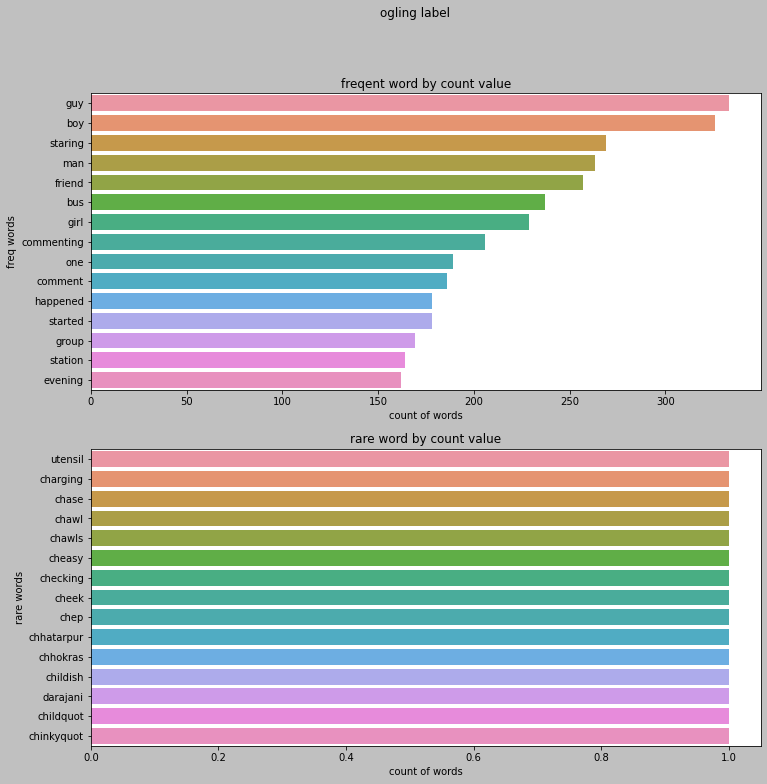

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'ogling', 15, 1, stop_word=False)

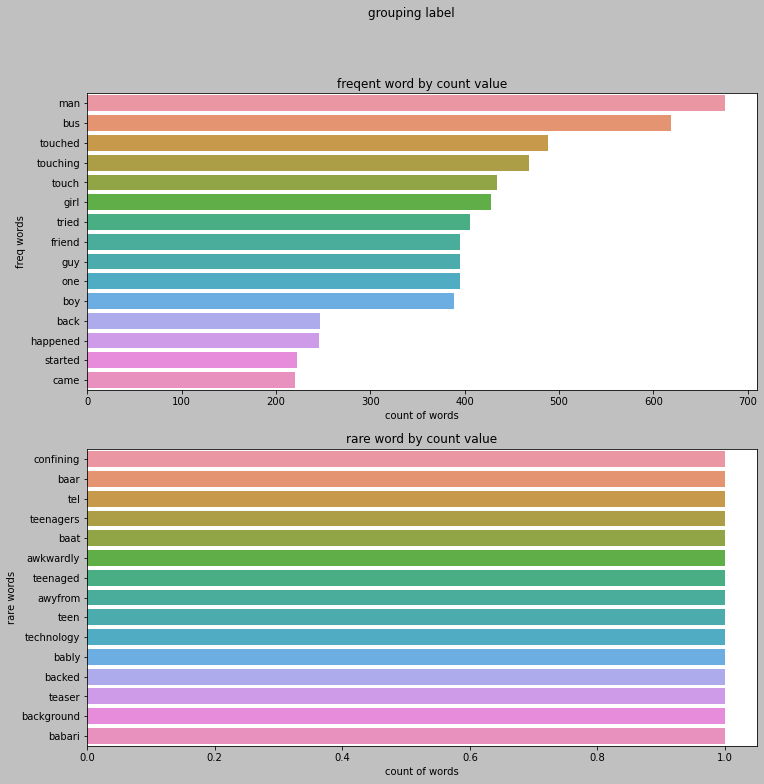

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'grouping', 15, 1, stop_word=False)

##### 1.2.2.5.3 VIZUALIZATION OF COMMENTING, OGLING, GROUPING LABEL BIIGRAM   BASED ON COUNTVECTORIZER WITH STOPWORDS

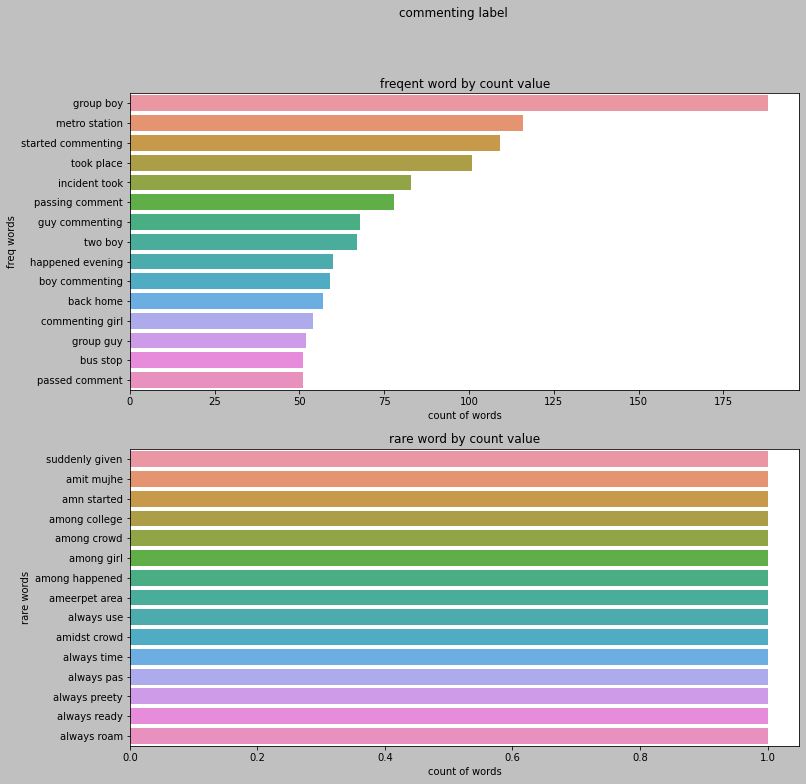

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'commenting', 15, 2, stop_word=True)

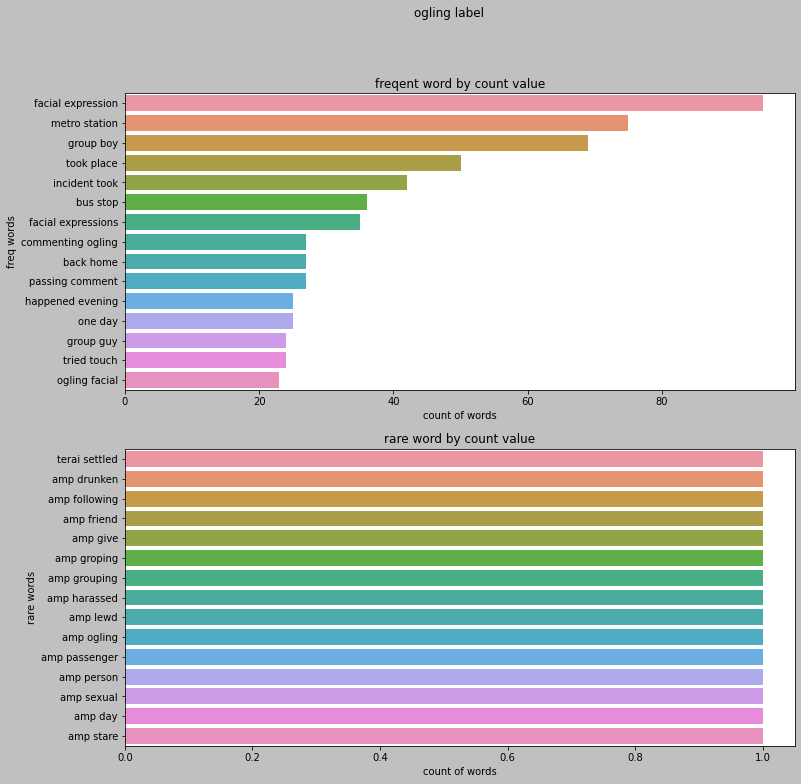

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'ogling', 15, 2, stop_word=True)

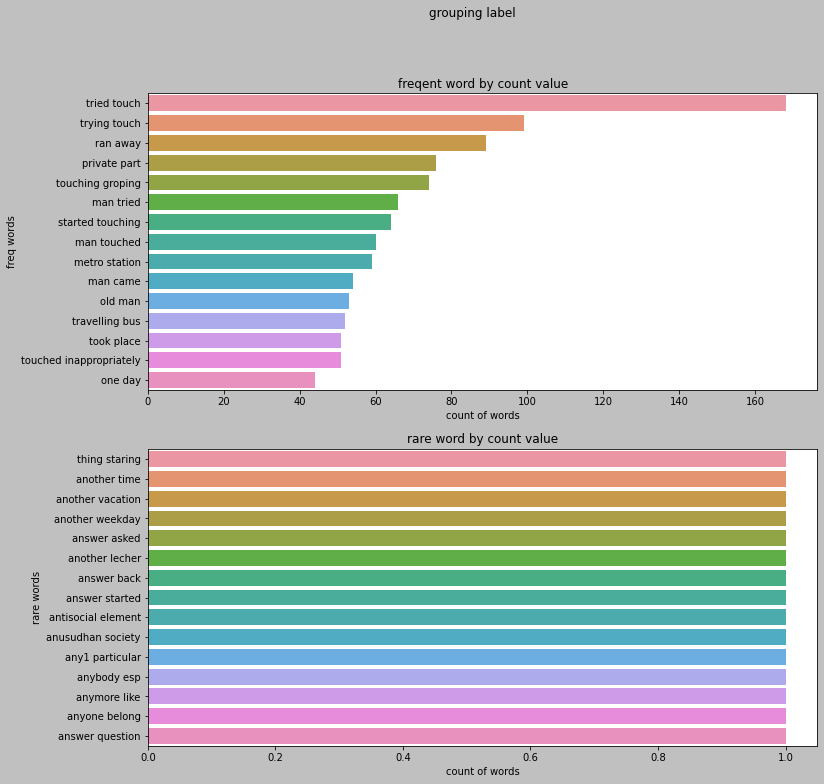

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'grouping', 15, 2, stop_word=True)

##### 1.2.2.5.4 VIZUALIZATION OF COMMENTING, OGLING, GROUPING LABEL TRIGRAM   BASED ON COUNTVECTORIZER WITH STOPWORDS

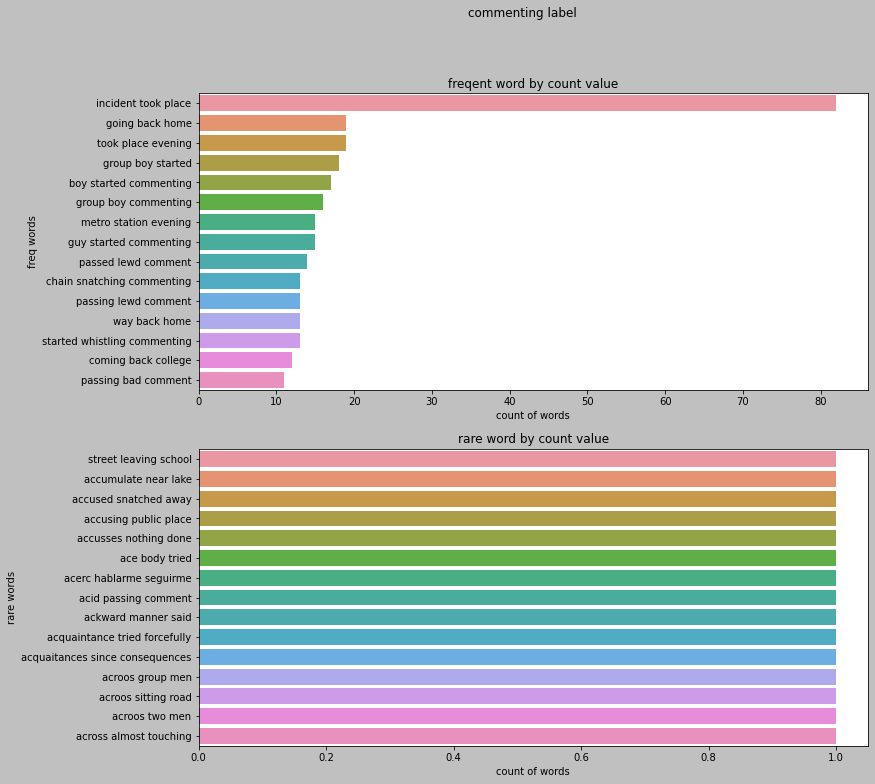

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'commenting', 15, 3, stop_word=True)

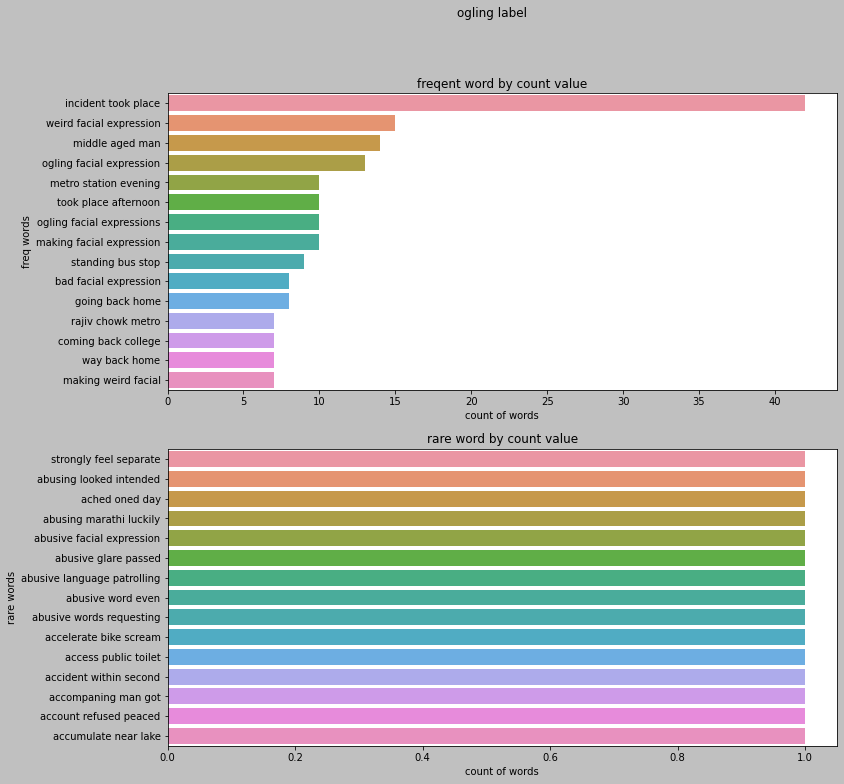

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'ogling', 15, 3, stop_word=True)

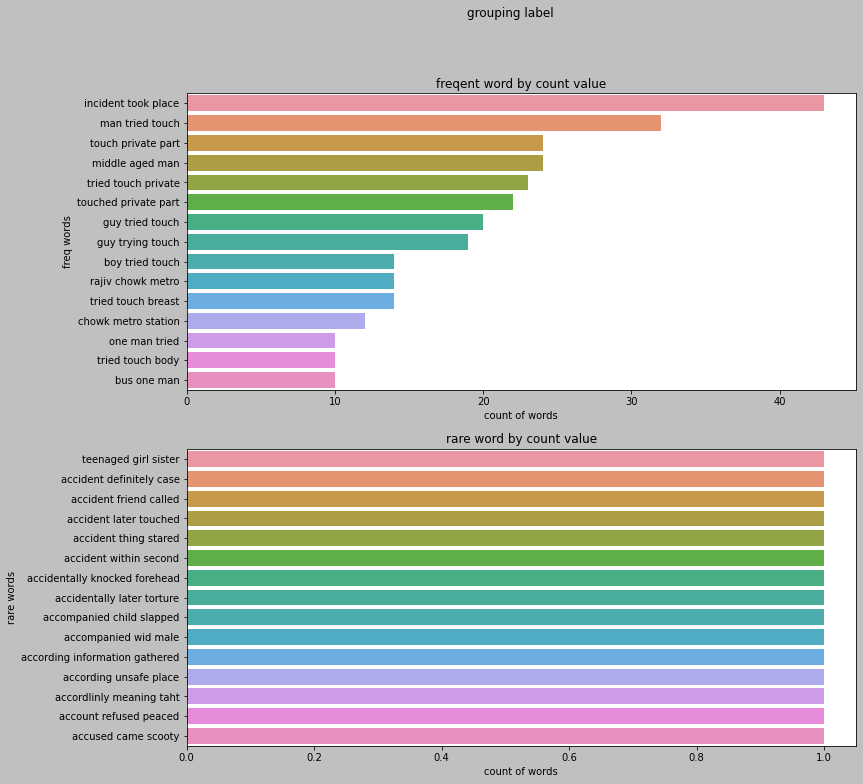

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'grouping', 15, 3, stop_word=True)

##### 1.2.2.5.5 VIZUALIZATION OF COMMENTING, OGLING, GROUPING LABEL FOURGRAM   BASED ON COUNTVECTORIZER WITH STOPWORDS

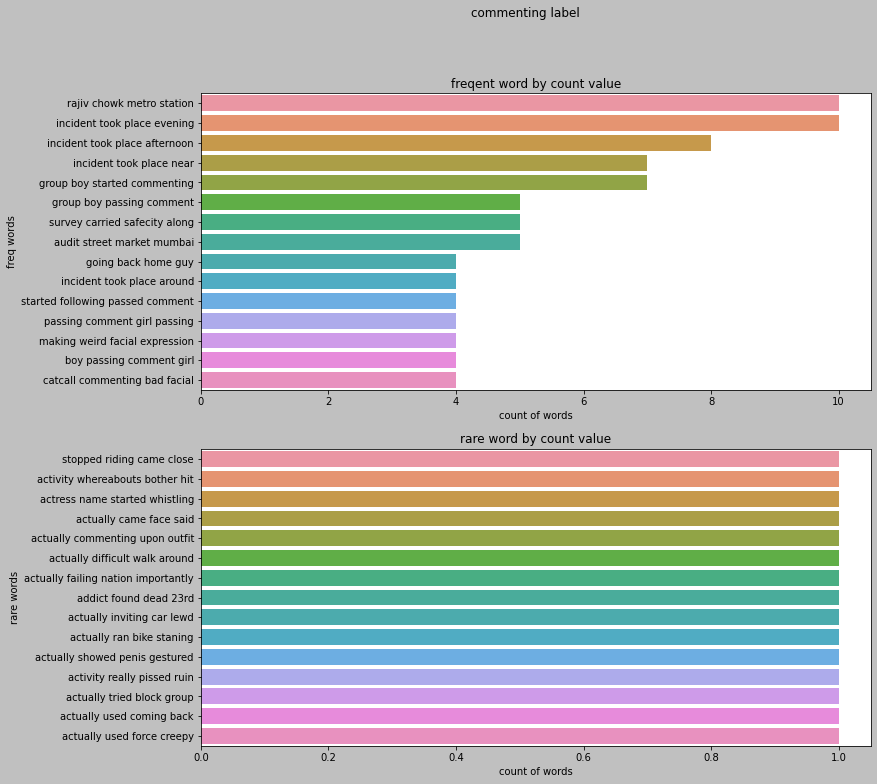

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'commenting', 15, 4, stop_word=True)

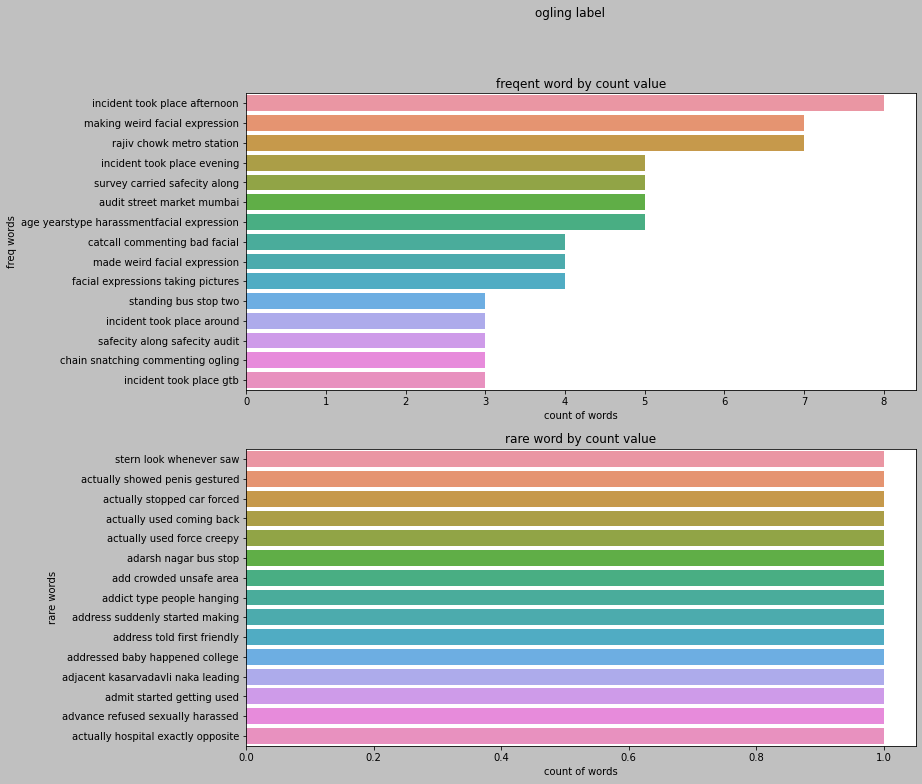

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'ogling', 15, 4, stop_word=True)

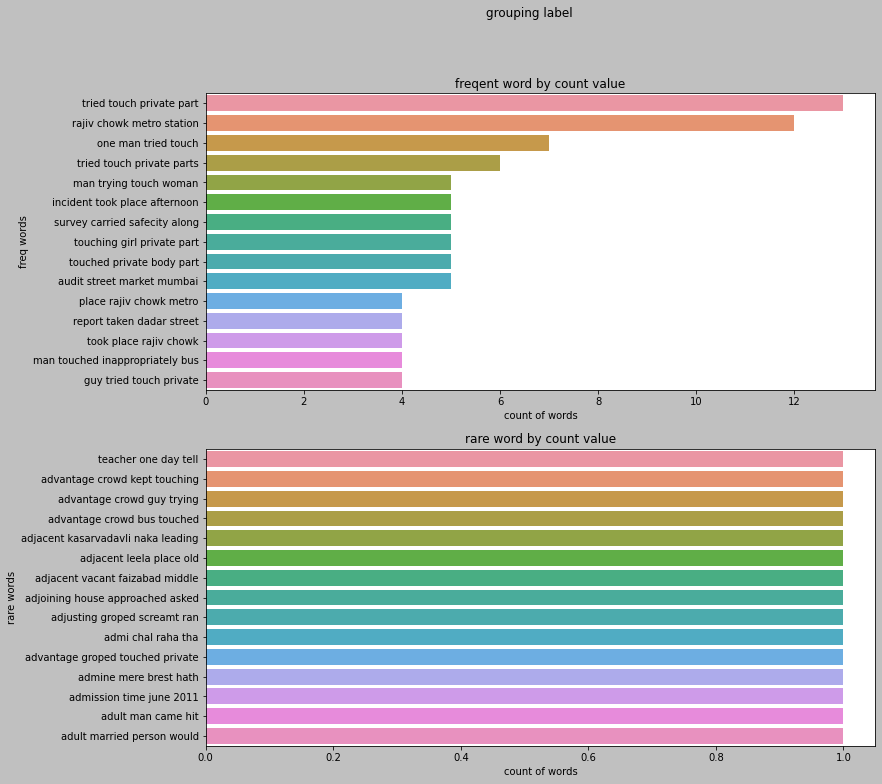

In [ ]:
vizulaize_countvec_rare_feq_word(combined_data, 'description', 'grouping', 15, 4, stop_word=True)

### <font color='green'>1.2.3 PLOTTING DATA FOR INSIGHTS INTO TEXT AND LABEL</font>

#### <font color='brown'>1.2.3.1 PLOT OF INCIDENCE HAVING SAME NUMBER OF WORDS UNIVARIATE</font>

In [ ]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039

def words_in_incidence(frame, column):

  '''frame : dataframe,
  column   : text column,
  return   : plot between no.of incidence having same count of words and number of words in each incidence'''

  word_count = frame[column].str.split().apply(len).value_counts()
  word_dict  = dict(word_count)
  word_dict  = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


  ind = np.arange(len(word_dict))
  fig = plt.figure(figsize=(20,5))
  fig.patch.set_facecolor('silver')
  p1 = plt.bar(ind, list(word_dict.values()))

  plt.ylabel('Number of words in each incidence')
  plt.xlabel('Number of incidence having same count of words')
  plt.title('Words for each incidence (text)')
  plt.xticks(ind, list(word_dict.keys()))
  plt.show()
  return word_count


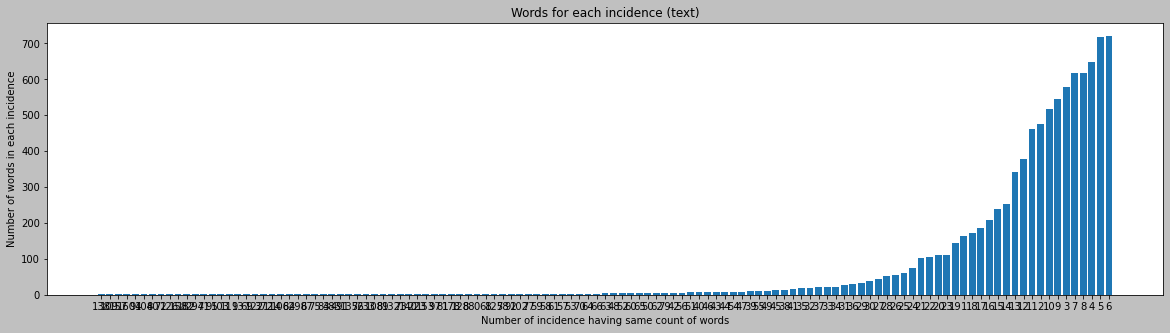

6      721
5      717
4      649
7      619
8      619
      ... 
89       1
132      1
73       1
140      1
223      1
Name: description, Length: 119, dtype: int64

In [ ]:
words_in_incidence(combined_data, 'description')

**OBSERVATION**

1. 6 (extreme right) incidence having more than 721 words.
2. 4 incidence have 649 words. 

#### <font color='brown'>1.2.3.2 PLOT OF DATA POINTS AND THEIR LENGTH OF TEXT (WORDS) UNIVARIATE</font>

Text(0, 0.5, 'words(lenght) in text')

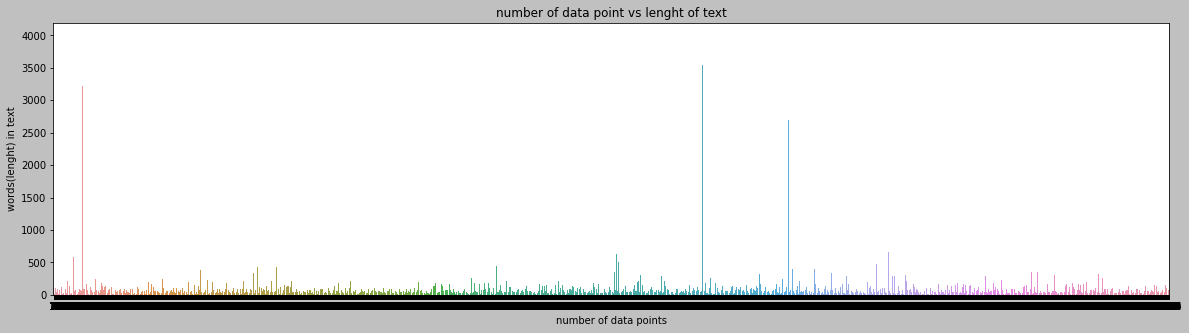

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.patch.set_facecolor('silver')
sns.barplot(x=combined_data['description'].index, y= combined_data['description'].astype(str).apply(len))
plt.title('number of data point vs lenght of text')
plt.xlabel('number of data points')
plt.ylabel('words(lenght) in text')

In [ ]:
print(f"max of words among all data points : {max(combined_data['description'].astype(str).apply(len))}")
print(f"min of words among all data points : {min(combined_data['description'].astype(str).apply(len))}")

max of words among all data points : 3992
min of words among all data points : 0


Text(0, 0.5, 'words(noun count)')

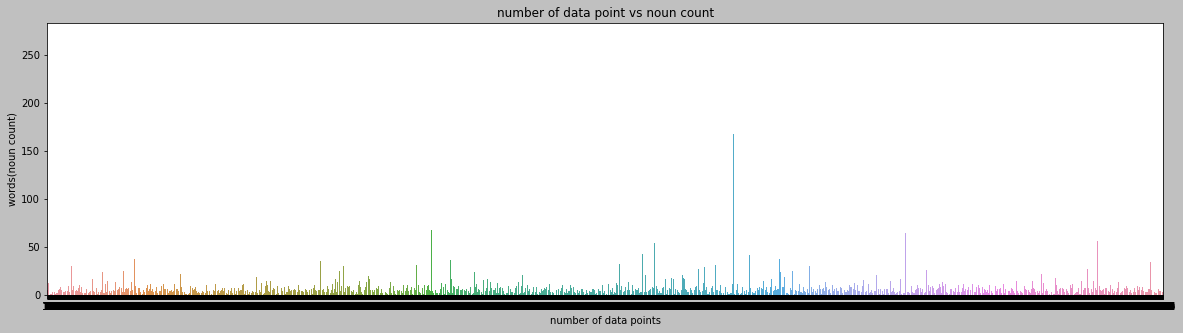

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.patch.set_facecolor('silver')
sns.barplot(x=combined_data['noun_count'].index, y= combined_data['noun_count'])  #.astype(str).apply(len))
plt.title('number of data point vs noun count')
plt.xlabel('number of data points')
plt.ylabel('words(noun count)')

In [ ]:
print(f"max of noun count among all data points : {max(combined_data['noun_count'])}")
print(f"min of noun count among all data points : {min(combined_data['noun_count'])}")

max of noun count among all data points : 270
min of noun count among all data points : 0


Text(0, 0.5, 'words(punctuation count)')

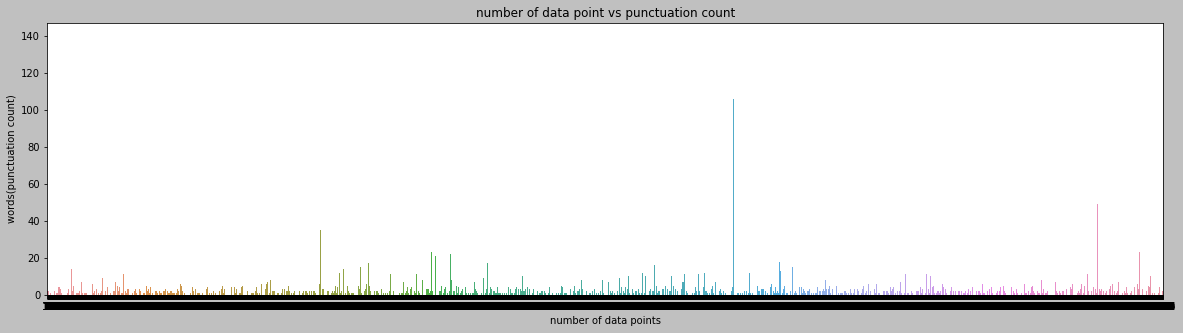

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.patch.set_facecolor('silver')
sns.barplot(x=combined_data['punctuation_count'].index, y= combined_data['punctuation_count'])  #.astype(str).apply(len))
plt.title('number of data point vs punctuation count')
plt.xlabel('number of data points')
plt.ylabel('words(punctuation count)')

In [ ]:
print(f"max of punctuation count among all data points : {max(combined_data['punctuation_count'])}")
print(f"min of punctuation count among all data points : {min(combined_data['punctuation_count'])}")

max of punctuation count among all data points : 140
min of punctuation count among all data points : 0


Text(0, 0.5, 'words(stopword count)')

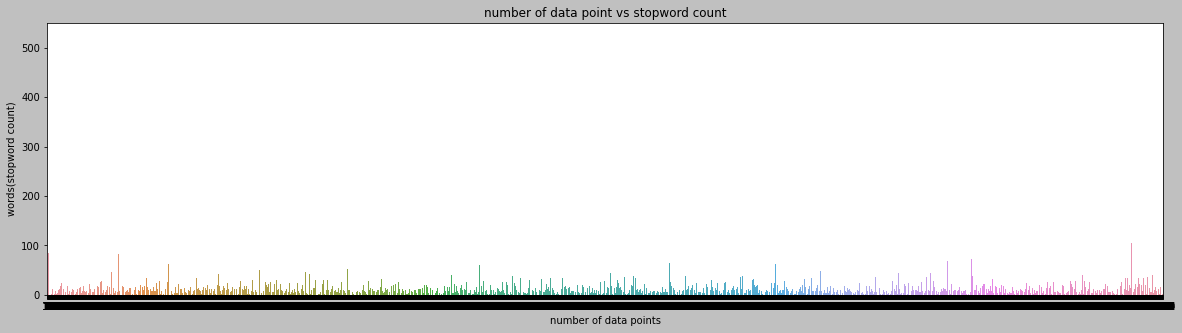

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.patch.set_facecolor('silver')
sns.barplot(x=combined_data['stopword_count'].index, y= combined_data['stopword_count'])  #.astype(str).apply(len))
plt.title('number of data point vs stopword count')
plt.xlabel('number of data points')
plt.ylabel('words(stopword count)')

In [ ]:
print(f"max of stopword count among all data points : {max(combined_data['stopword_count'])}")
print(f"min of stopword count among all data points : {min(combined_data['stopword_count'])}")

max of stopword count among all data points : 524
min of stopword count among all data points : 0


#### <font color='brown'>1.2.3.3 PLOT OF EACH LABEL POSITIVE (1) OR NEGATIVE (0) CLAIM UNIVARIATE</font>

In [ ]:
commenting_claim_pos = combined_data[combined_data['commenting']==1]['description'].str.split().apply(len)
#commenting_claim_pos.values

ogling_claim_pos = combined_data[combined_data['ogling']==1]['description'].str.split().apply(len)
#ogling_claim_pos.values

grouping_claim_pos = combined_data[combined_data['grouping']==1]['description'].str.split().apply(len)
#grouping_claim_pos.values

commenting_claim_neg = combined_data[combined_data['commenting']==0]['description'].str.split().apply(len)
#commenting_claim_neg.values

ogling_claim_neg = combined_data[combined_data['ogling']==0]['description'].str.split().apply(len)
#ogling_claim_neg.values

grouping_claim_neg = combined_data[combined_data['grouping']==0]['description'].str.split().apply(len)
#grouping_claim_neg.values

In [ ]:
def distribution(frame, column):
  fig = plt.figure(figsize=(8,5))
  fig.patch.set_facecolor('silver')
  sns.histplot(frame[column].values, kde=True,  linewidth=0, color='b')
  plt.title(f'density/count plot in {column} column')
  plt.xlabel(f'values in each data points {column}')
  plt.ylabel(f'count of values having same {column} in data')  ##equivalent of .value_counts()
  plt.legend()
  plt.show()

No handles with labels found to put in legend.


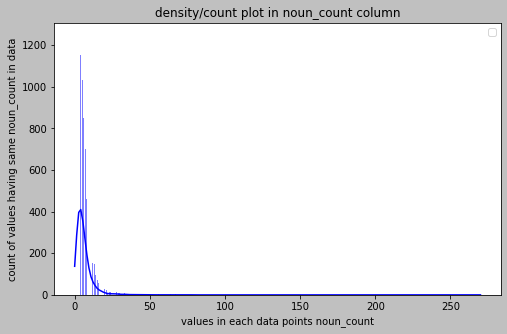

In [ ]:
distribution(combined_data, 'noun_count')

In [ ]:
print(f"max of noun count among all data points : {max(combined_data['noun_count'].values)}")
print(f"min of noun count among all data points : {min(combined_data['noun_count'].values)}")
print(' ')
print(f"max of count of values having same noun count  : {max(combined_data['noun_count'].value_counts())}")
print(f"min of count of values having same noun count  : {min(combined_data['noun_count'].value_counts())}")

max of noun count among all data points : 270
min of noun count among all data points : 0
 
max of count of values having same noun count  : 1244
min of count of values having same noun count  : 1


No handles with labels found to put in legend.


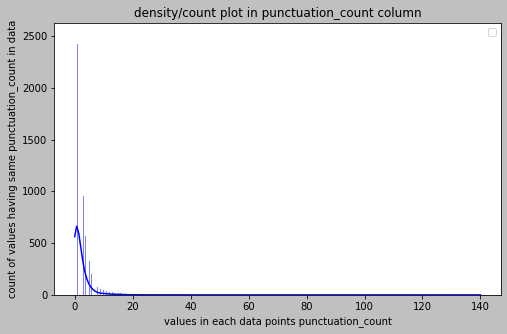

In [ ]:
distribution(combined_data, 'punctuation_count')

In [ ]:
print(f"max of punctuation count among all data points : {max(combined_data['punctuation_count'].values)}")
print(f"min of punctuation count among all data points : {min(combined_data['punctuation_count'].values)}")
print(' ')
print(f"max of count of values having same punctuation count : {max(combined_data['punctuation_count'].value_counts())}")
print(f"min of count of values having same punctuation count : {min(combined_data['punctuation_count'].value_counts())}")

max of punctuation count among all data points : 140
min of punctuation count among all data points : 0
 
max of count of values having same punctuation count : 2500
min of count of values having same punctuation count : 1


No handles with labels found to put in legend.


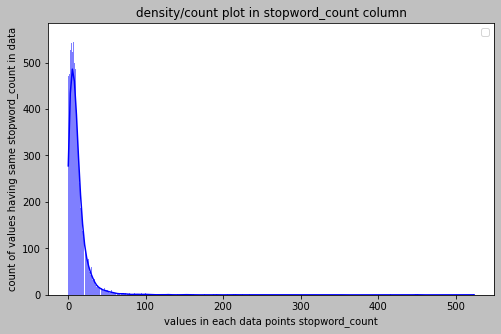

In [ ]:
distribution(combined_data, 'stopword_count')

In [ ]:
print(f"max of stopword count among all data points : {max(combined_data['stopword_count'].values)}")
print(f"min of stopword count among all data points : {min(combined_data['stopword_count'].values)}")
print(' ')
print(f"max of count of values having sme stopword count  : {max(combined_data['stopword_count'].value_counts())}")
print(f"min of count of values having sme stopword count  : {min(combined_data['stopword_count'].value_counts())}")

max of stopword count among all data points : 524
min of stopword count among all data points : 0
 
max of count of values having sme stopword count  : 557
min of count of values having sme stopword count  : 1


##### 1.2.3.3.1 PLOT OF COMMENTING LABEL POSITIVE (1) OR NEGATIVE (0) CLAIM UNIVARIATE

In [ ]:
def distribution_plt_pos_neg(posi, negi, label):
  fig = plt.figure(figsize=(8,5))
  fig.patch.set_facecolor('silver')
  sns.histplot(posi.values, kde=True, linewidth=0, label="incident happen", color='r')
  sns.histplot(negi.values, kde=True, linewidth=0, label="incident not happen", color='g')
  plt.title(f'density/count plot in {label} label')
  plt.xlabel('lenght of words in each description pos/neg')
  plt.ylabel('count of instances having same word counts (frequency)')  ##equivalent of .value_counts()
  plt.legend()
  plt.show()

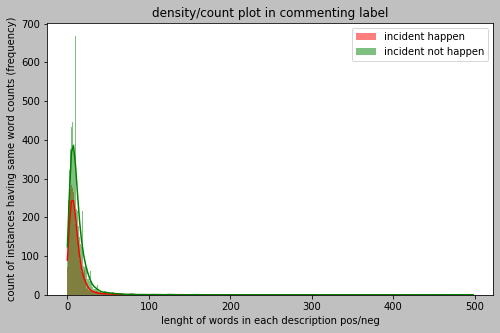

In [ ]:
distribution_plt_pos_neg(commenting_claim_pos, commenting_claim_neg, 'commenting')

In [ ]:
print('conclusion from above commenting label graph :')
print('-'*46)
print(f'max lenght of words in each description pos : {max(commenting_claim_pos.values)}')
print(f'max lenght of words in each description neg : {max(commenting_claim_neg.values)}')
print(f'count of instances having same word counts (frequency) pos : {max(commenting_claim_pos.value_counts())}')
print(f'count of instances having same word counts (frequency) neg : {max(commenting_claim_neg.value_counts())}')
print(' ')
print('incidence happen and not happen have very similar distribution with not incidence having higher peak.')

conclusion from above commenting label graph :
----------------------------------------------
max lenght of words in each description pos : 491
max lenght of words in each description neg : 498
count of instances having same word counts (frequency) pos : 283
count of instances having same word counts (frequency) neg : 446
 
incidence happen and not happen have very similar distribution with not incidence having higher peak.


##### 1.2.3.3.2 PLOT OF OGLING LABEL POSITIVE (1) OR NEGATIVE (0) CLAIM UNIVARIATE

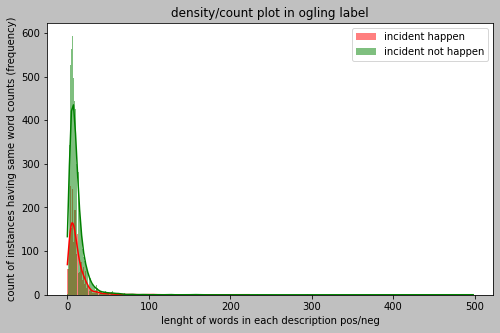

In [ ]:
distribution_plt_pos_neg(ogling_claim_pos, ogling_claim_neg, 'ogling')

In [ ]:
print('conclusion from above ogling label graph :')
print('-'*42)
print(f'max lenght of words in each description pos : {max(ogling_claim_pos.values)}')
print(f'max lenght of words in each description neg : {max(ogling_claim_neg.values)}')
print(f'count of instances having same word counts (frequency) pos : {max(ogling_claim_pos.value_counts())}')
print(f'count of instances having same word counts (frequency) neg : {max(ogling_claim_neg.value_counts())}')
print(' ')
print('incidence happen and not happen have very similar distribution with not incidence having higher peak.')

conclusion from above ogling label graph :
------------------------------------------
max lenght of words in each description pos : 223
max lenght of words in each description neg : 498
count of instances having same word counts (frequency) pos : 153
count of instances having same word counts (frequency) neg : 593
 
incidence happen and not happen have very similar distribution with not incidence having higher peak.


##### 1.2.3.3.3 PLOT OF GROUPING LABEL POSITIVE (1) OR NEGATIVE (0) CLAIM UNIVARIATE

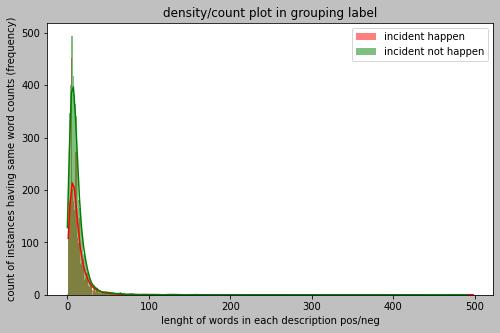

In [ ]:
distribution_plt_pos_neg(grouping_claim_pos, grouping_claim_neg, 'grouping')

In [ ]:
print('conclusion from above grouping label graph :')
print('-'*44)
print(f'max lenght of words in each description pos : {max(grouping_claim_pos.values)}')
print(f'max lenght of words in each description neg : {max(grouping_claim_neg.values)}')
print(f'count of instances having same word counts (frequency) pos : {max(grouping_claim_pos.value_counts())}')
print(f'count of instances having same word counts (frequency) neg : {max(grouping_claim_neg.value_counts())}')
print(' ')
print('incidence happen and not happen have very similar distribution with not incidence having higher peak.')

conclusion from above grouping label graph :
--------------------------------------------
max lenght of words in each description pos : 498
max lenght of words in each description neg : 491
count of instances having same word counts (frequency) pos : 228
count of instances having same word counts (frequency) neg : 494
 
incidence happen and not happen have very similar distribution with not incidence having higher peak.


##### 1.2.3.3.4 PLOT OF COMMENTING, OGLING, GROUPING LABEL POSITIVE (1)  CLAIM MULTIVARIATE

In [ ]:
  ##distribution of pos claim in each label
  def claim(x,y,z, lab):
    fig = plt.figure(figsize=(8,5))
    fig.patch.set_facecolor('silver')
    sns.histplot(x.values, kde=True, linewidth=0, label="commenting", color='r')
    sns.histplot(y.values, kde=True, linewidth=0, label="ogling", color='b')
    sns.histplot(z.values, kde=True, linewidth=0, label="grouping", color='g')
    plt.title(f'count/density in each label having {lab} claim')
    plt.xlabel('lenght of words in each description pos/neg')
    plt.ylabel('count of instances having same word counts (frequency)')  ##equivalent of .value_counts()
    plt.legend()
    plt.show()

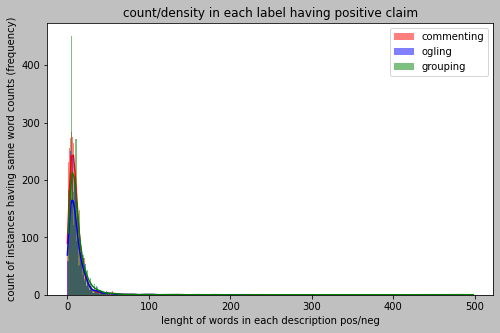

In [ ]:
claim(commenting_claim_pos, ogling_claim_pos, grouping_claim_pos, 'positive')

In [ ]:
print('conclusion from above all three label with positive claim graph :')
print('-'*65)
print(f'commenting max lenght of words in each description pos   : {max(commenting_claim_pos.values)}')
print(f'ogling max lenght of words in each description pos       : {max(ogling_claim_pos.values)}')
print(f'grouping max lenght of words in each description pos     : {max(grouping_claim_pos.values)}')
print(f'commenting count of instances having same word counts (frequency) pos : {max(commenting_claim_pos.value_counts())}')
print(f'ogling count of instances having same word counts (frequency) pos     : {max(ogling_claim_pos.value_counts())}')
print(f'grouping count of instances having same word counts (frequency) pos   : {max(grouping_claim_pos.value_counts())}')
print(' ')
print('commenting, ogling, grouping with positive claims have very similar distribution with higher peak in order of commenting, grouping, ogling.')

conclusion from above all three label with positive claim graph :
-----------------------------------------------------------------
commenting max lenght of words in each description pos   : 491
ogling max lenght of words in each description pos       : 223
grouping max lenght of words in each description pos     : 498
commenting count of instances having same word counts (frequency) pos : 283
ogling count of instances having same word counts (frequency) pos     : 153
grouping count of instances having same word counts (frequency) pos   : 228
 
commenting, ogling, grouping with positive claims have very similar distribution with higher peak in order of commenting, grouping, ogling.


##### 1.2.3.3.5 PLOT OF COMMENTING, OGLING, GROUPING LABEL NEGATIVE (0)  CLAIM MULTIVARIATE

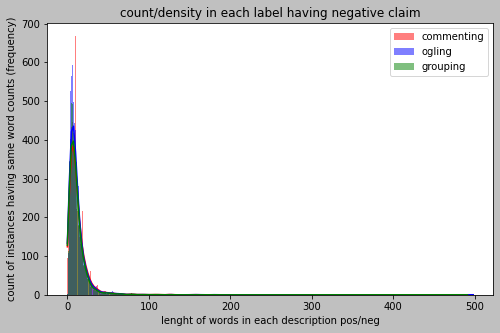

In [ ]:
claim(commenting_claim_neg, ogling_claim_neg, grouping_claim_neg, 'negative')

In [ ]:
print('conclusion from above all three label with negative claim graph :')
print('-'*65)
print(f'commenting max lenght of words in each description neg : {max(commenting_claim_neg.values)}')
print(f'ogling max lenght of words in each description neg     : {max(ogling_claim_neg.values)}')
print(f'grouping max lenght of words in each description neg   : {max(grouping_claim_neg.values)}')
print(f'commenting count of instances having same word counts (frequency) neg : {max(commenting_claim_neg.value_counts())}')
print(f'ogling count of instances having same word counts (frequency) neg     : {max(ogling_claim_neg.value_counts())}')
print(f'grouping count of instances having same word counts (frequency) neg   : {max(grouping_claim_neg.value_counts())}')
print(' ')
print('commenting, ogling, grouping with negative claims have very similar distribution with higher peak in order of ogling, grouping, commenting.')

conclusion from above all three label with negative claim graph :
-----------------------------------------------------------------
commenting max lenght of words in each description neg : 498
ogling max lenght of words in each description neg     : 498
grouping max lenght of words in each description neg   : 491
commenting count of instances having same word counts (frequency) neg : 446
ogling count of instances having same word counts (frequency) neg     : 593
grouping count of instances having same word counts (frequency) neg   : 494
 
commenting, ogling, grouping with negative claims have very similar distribution with higher peak in order of ogling, grouping, commenting.


#### <font color='brown'>1.2.3.4 BOX PLOT</font>

##### 1.2.3.4.1 BOX PLOT FOR LABEL COMMENTING

In [ ]:
def box_plot(a,b, lab):
  fig = plt.figure(figsize=(8,8))
  fig.patch.set_facecolor('silver')
  plt.boxplot(np.array([a,b], dtype=object))
  plt.title(f'box plot for words in {lab} label for incident right and wrong claim ')
  plt.xticks([1,2],('right claim','wrong claim'))
  plt.ylabel(f'Words in {lab} label')
  plt.grid()
  plt.show()

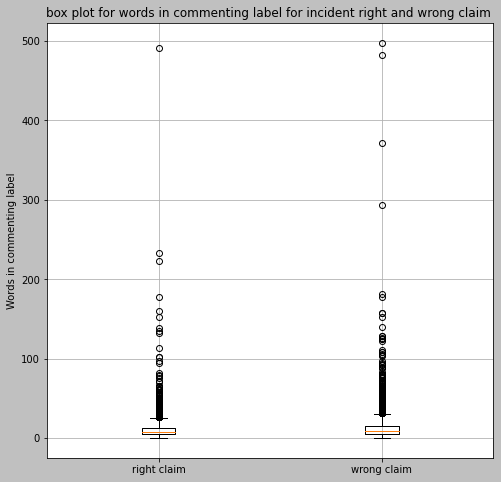

In [ ]:
box_plot(commenting_claim_pos, commenting_claim_neg, 'commenting')

In [ ]:
print('conclusion from above plot of right and wrong claim of commenting label :')
print('-'*75)
print(f'25 percentile of commenting label words of postive claim : {np.percentile(commenting_claim_pos, 25)}, and negative : {np.percentile(commenting_claim_neg, 25)}')
print(f'median of commenting label words of postive claim        : {np.median(commenting_claim_pos)}, and negative : {np.median(commenting_claim_neg)}')
print(f'75 percentile of commenting label words of postive claim : {np.percentile(commenting_claim_pos, 75)}, and negative : {np.percentile(commenting_claim_neg, 75)}')
print(' ')
print(f'commenting label postive claim iqr  : {np.percentile(commenting_claim_pos, 75) - np.percentile(commenting_claim_pos, 25)}')
print(f'commenting label negative claim iqr : {np.percentile(commenting_claim_neg, 75) - np.percentile(commenting_claim_neg, 25)}')
print(' ')
print(f'acc. theory commenting label positive claim outliers words after  : {(np.percentile(commenting_claim_pos, 75) - np.percentile(commenting_claim_pos, 25))*1.5}')
print(f'acc. theory commenting label negative claim outliers words after  : {(np.percentile(commenting_claim_neg, 75) - np.percentile(commenting_claim_neg, 25))*1.5}')
print(' ')
print(f'range of commenting label positive claim words   : {max(commenting_claim_pos) - min(commenting_claim_pos)}')
print(f'range of commenting label negative claim words   : {max((commenting_claim_pos) - min(commenting_claim_neg))}')


conclusion from above plot of right and wrong claim of commenting label :
---------------------------------------------------------------------------
25 percentile of commenting label words of postive claim : 5.0, and negative : 5.0
median of commenting label words of postive claim        : 8.0, and negative : 9.0
75 percentile of commenting label words of postive claim : 13.0, and negative : 15.0
 
commenting label postive claim iqr  : 8.0
commenting label negative claim iqr : 10.0
 
acc. theory commenting label positive claim outliers words after  : 12.0
acc. theory commenting label negative claim outliers words after  : 15.0
 
range of commenting label positive claim words   : 491
range of commenting label negative claim words   : 491


##### 1.2.3.4.2 BOX PLOT FOR LABEL OGLING

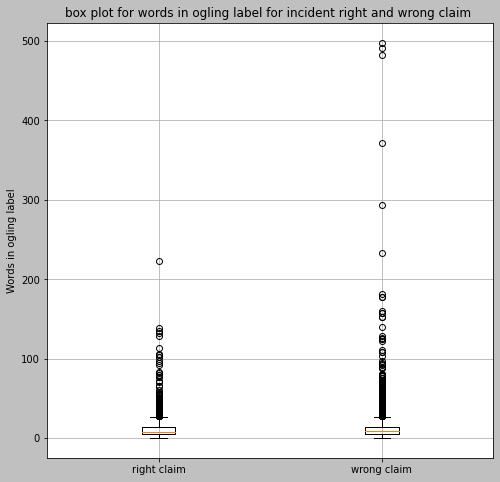

In [ ]:
box_plot(ogling_claim_pos, ogling_claim_neg, 'ogling')

In [ ]:
print('conclusion from above plot of right and wrong claim of ogling label :')
print('-'*75)
print(f'25 percentile of ogling label words of postive claim : {np.percentile(ogling_claim_pos, 25)}, and negative : {np.percentile(ogling_claim_neg, 25)}')
print(f'median of ogling label words of postive claim        : {np.median(ogling_claim_pos)}, and negative : {np.median(ogling_claim_neg)}')
print(f'75 percentile of ogling label words of postive claim : {np.percentile(ogling_claim_pos, 75)}, and negative : {np.percentile(ogling_claim_neg, 75)}')
print(' ')
print(f'ogling label postive claim iqr  : {np.percentile(ogling_claim_pos, 75) - np.percentile(ogling_claim_pos, 25)}')
print(f'ogling label negative claim iqr : {np.percentile(ogling_claim_neg, 75) - np.percentile(ogling_claim_neg, 25)}')
print(' ')
print(f'acc. theory ogling label positive claim outliers words after  : {(np.percentile(ogling_claim_pos, 75) - np.percentile(ogling_claim_pos, 25))*1.5}')
print(f'acc. theory ogling label negative claim outliers words after  : {(np.percentile(ogling_claim_neg, 75) - np.percentile(ogling_claim_neg, 25))*1.5}')
print(' ')
print(f'range of ogling label positive claim words   : {max(ogling_claim_pos) - min(ogling_claim_pos)}')
print(f'range of ogling label negative claim words   : {max((ogling_claim_pos) - min(ogling_claim_neg))}')


conclusion from above plot of right and wrong claim of ogling label :
---------------------------------------------------------------------------
25 percentile of ogling label words of postive claim : 5.0, and negative : 5.0
median of ogling label words of postive claim        : 8.0, and negative : 9.0
75 percentile of ogling label words of postive claim : 14.0, and negative : 14.0
 
ogling label postive claim iqr  : 9.0
ogling label negative claim iqr : 9.0
 
acc. theory ogling label positive claim outliers words after  : 13.5
acc. theory ogling label negative claim outliers words after  : 13.5
 
range of ogling label positive claim words   : 223
range of ogling label negative claim words   : 223


##### 1.2.3.4.3 BOX PLOT FOR LABEL GROUPING

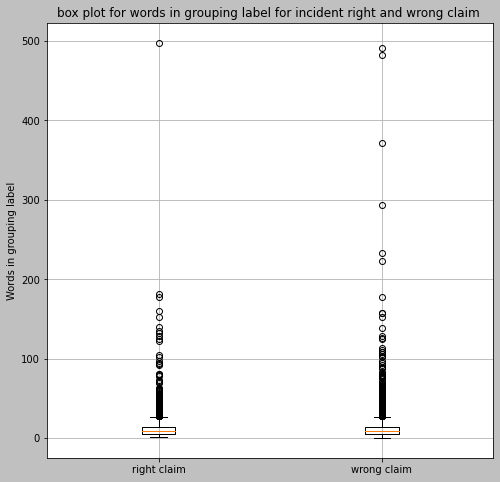

In [ ]:
box_plot(grouping_claim_pos, grouping_claim_neg, 'grouping')

In [ ]:
print('conclusion from above plot of right and wrong claim of grouping label :')
print('-'*75)
print(f'25 percentile of grouping label words of postive claim : {np.percentile(grouping_claim_pos, 25)}, and negative : {np.percentile(grouping_claim_neg, 25)}')
print(f'median of grouping label words of postive claim        : {np.median(grouping_claim_pos)}, and negative : {np.median(grouping_claim_neg)}')
print(f'75 percentile of grouping label words of postive claim : {np.percentile(grouping_claim_pos, 75)}, and negative : {np.percentile(grouping_claim_neg, 75)}')
print(' ')
print(f'grouping label postive claim iqr  : {np.percentile(grouping_claim_pos, 75) - np.percentile(grouping_claim_pos, 25)}')
print(f'grouping label negative claim iqr : {np.percentile(grouping_claim_neg, 75) - np.percentile(grouping_claim_neg, 25)}')
print(' ')
print(f'acc. theory grouping label positive claim outliers words after : {(np.percentile(grouping_claim_pos, 75) - np.percentile(grouping_claim_pos, 25))*1.5}')
print(f'acc. theory grouping label negative claim outliers words after : {(np.percentile(grouping_claim_neg, 75) - np.percentile(grouping_claim_neg, 25))*1.5}')
print(' ')
print(f'range of grouping label positive claim words   : {max(grouping_claim_pos) - min(grouping_claim_pos)}')
print(f'range of grouping label negative claim words   : {max((grouping_claim_pos) - min(grouping_claim_neg))}')

conclusion from above plot of right and wrong claim of grouping label :
---------------------------------------------------------------------------
25 percentile of grouping label words of postive claim : 5.0, and negative : 5.0
median of grouping label words of postive claim        : 9.0, and negative : 9.0
75 percentile of grouping label words of postive claim : 14.0, and negative : 14.0
 
grouping label postive claim iqr  : 9.0
grouping label negative claim iqr : 9.0
 
acc. theory grouping label positive claim outliers words after : 13.5
acc. theory grouping label negative claim outliers words after : 13.5
 
range of grouping label positive claim words   : 497
range of grouping label negative claim words   : 498


In [ ]:
def box_plot_n(frame, column):
  fig = plt.figure(figsize=(8,8))
  fig.patch.set_facecolor('silver')
  plt.boxplot(frame[column])
  plt.title(f'box plot of {column} ')
  #plt.xticks([1,2],('right claim','wrong claim'))
  plt.ylabel(f'count in {column}')
  plt.grid()
  plt.show()

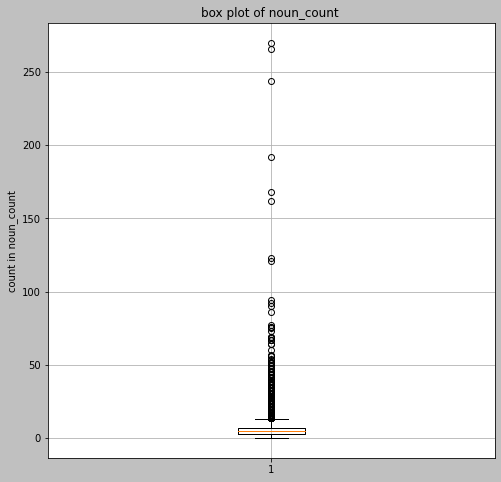

In [ ]:
box_plot_n(combined_data, 'noun_count')

In [ ]:
print('conclusion from above plot of noun count :')
print('-'*45)
print(f'25 percentile noun count : {np.percentile(combined_data["noun_count"].values, 25)}')
print(f'median  noun count       : {np.median(combined_data["noun_count"].values)}')
print(f'75 percentile noun count : {np.percentile(combined_data["noun_count"].values, 75)}')
print(' ')
print(f'noun count iqr  : {np.percentile(combined_data["noun_count"].values, 75) - np.percentile(combined_data["noun_count"].values, 25)}')
print(' ')
print(f'acc. theory noun count outliers : {(np.percentile(combined_data["noun_count"].values, 75) - np.percentile(combined_data["noun_count"].values, 25))*1.5}')
print(' ')
print(f'range of noun count   : {max(combined_data["noun_count"].values) - min(combined_data["noun_count"].values)}')


conclusion from above plot of noun count :
---------------------------------------------
25 percentile noun count : 3.0
median  noun count       : 5.0
75 percentile noun count : 7.0
 
noun count iqr  : 4.0
 
acc. theory noun count outliers : 6.0
 
range of noun count   : 270


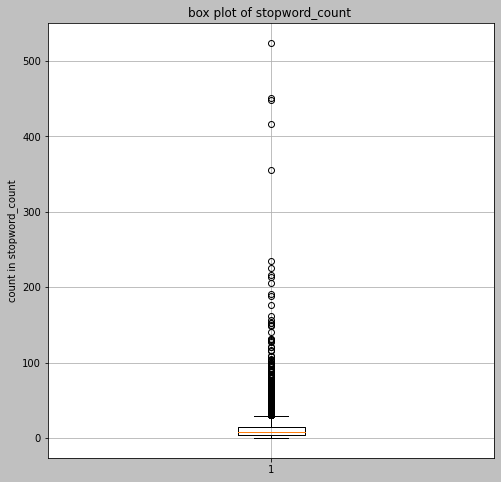

In [ ]:
box_plot_n(combined_data, 'stopword_count')

In [ ]:
print('conclusion from above plot of stopwords count :')
print('-'*45)
print(f'25 percentile stopwords count : {np.percentile(combined_data["stopword_count"].values, 25)}')
print(f'median  stopwords count       : {np.median(combined_data["stopword_count"].values)}')
print(f'75 percentile stopwords count : {np.percentile(combined_data["stopword_count"].values, 75)}')
print(' ')
print(f'stopwords count iqr  : {np.percentile(combined_data["stopword_count"].values, 75) - np.percentile(combined_data["stopword_count"].values, 25)}')
print(' ')
print(f'acc. theory stopwords count outliers : {(np.percentile(combined_data["stopword_count"].values, 75) - np.percentile(combined_data["stopword_count"].values, 25))*1.5}')
print(' ')
print(f'range of stopwords count   : {max(combined_data["stopword_count"].values) - min(combined_data["stopword_count"].values)}')

conclusion from above plot of stopwords count :
---------------------------------------------
25 percentile stopwords count : 4.0
median  stopwords count       : 8.0
75 percentile stopwords count : 14.0
 
stopwords count iqr  : 10.0
 
acc. theory stopwords count outliers : 15.0
 
range of stopwords count   : 524


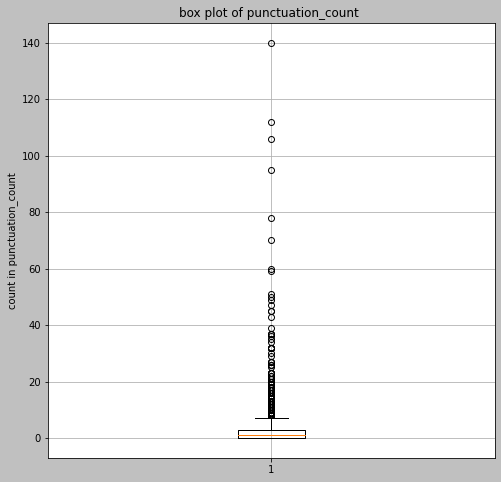

In [ ]:
box_plot_n(combined_data, 'punctuation_count')

In [ ]:
print('conclusion from above plot of punctuation count :')
print('-'*50)
print(f'25 percentile punctuation count : {np.percentile(combined_data["punctuation_count"].values, 25)}')
print(f'median  punctuation count       : {np.median(combined_data["punctuation_count"].values)}')
print(f'75 percentile punctuation count : {np.percentile(combined_data["punctuation_count"].values, 75)}')
print(' ')
print(f'punctuation count iqr  : {np.percentile(combined_data["punctuation_count"].values, 75) - np.percentile(combined_data["punctuation_count"].values, 25)}')
print(' ')
print(f'acc. theory punctuation count outliers : {(np.percentile(combined_data["punctuation_count"].values, 75) - np.percentile(combined_data["punctuation_count"].values, 25))*1.5}')
print(' ')
print(f'range of punctuation count   : {max(combined_data["punctuation_count"].values) - min(combined_data["punctuation_count"].values)}')

conclusion from above plot of punctuation count :
--------------------------------------------------
25 percentile punctuation count : 0.0
median  punctuation count       : 1.0
75 percentile punctuation count : 3.0
 
punctuation count iqr  : 3.0
 
acc. theory punctuation count outliers : 4.5
 
range of punctuation count   : 140


##### 1.2.3.4.4 INSPECTING MORE ON PERCENTILES

In [ ]:
def percentile_range(frame,column,a,b,c):
  d_len  =  frame[column].apply(len)
  for i in range(a,b,c):
    print(f'{i} th percentile : {np.percentile(d_len,i)}')


In [ ]:
import math

def percentile_float(frame, column, perc):
  d_len  =  frame[column].apply(len)
  size = len(d_len)
  for i in perc:
    print(f'{i} th percentile {sorted(d_len)[int(math.ceil(int(size * i) / 100)) -1]}')


In [ ]:
percentile_range(combined_data, 'description', 0,110,10)

0 th percentile : 0.0
10 th percentile : 21.0
20 th percentile : 30.0
30 th percentile : 38.0
40 th percentile : 47.0
50 th percentile : 57.0
60 th percentile : 68.0
70 th percentile : 82.0
80 th percentile : 104.20000000000073
90 th percentile : 144.0
100 th percentile : 3992.0


In [ ]:
percentile_range(combined_data, 'description', 90,101,1)

90 th percentile : 144.0
91 th percentile : 150.54000000000087
92 th percentile : 158.47999999999956
93 th percentile : 168.0
94 th percentile : 178.35999999999876
95 th percentile : 192.0
96 th percentile : 213.23999999999978
97 th percentile : 242.1800000000003
98 th percentile : 294.0
99 th percentile : 401.0599999999995
100 th percentile : 3992.0


In [ ]:
perc = [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9]
percentile_float(combined_data, 'description', perc)

99.1 th percentile 418
99.2 th percentile 439
99.3 th percentile 462
99.4 th percentile 517
99.5 th percentile 554
99.6 th percentile 653
99.7 th percentile 735
99.8 th percentile 880
99.9 th percentile 1223


In [ ]:
perc = [99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99]
percentile_float(combined_data, 'description', perc)

99.91 th percentile 1239
99.92 th percentile 1262
99.93 th percentile 1481
99.94 th percentile 1591
99.95 th percentile 1849
99.96 th percentile 2695
99.97 th percentile 3213
99.98 th percentile 3546
99.99 th percentile 3992


In [ ]:
def top_30(frame,column):

  '''takes frame : dataframe
     column      : text column
     returns     : top 30 len word counts'''
     
  kl = {}
  d_s =  frame[column].apply(len).values
  for i in range(len(d_s)):
    kl[i] = d_s[i]
  return sorted(kl.items(), key=lambda x: x[1], reverse=True)[:30]

top_30(combined_data, 'description')

[(3261, 3992),
 (5347, 3546),
 (239, 3213),
 (6056, 2695),
 (5654, 1849),
 (4124, 1591),
 (8392, 1481),
 (5459, 1262),
 (2616, 1239),
 (1177, 1223),
 (9074, 1109),
 (1087, 1032),
 (3862, 1011),
 (6444, 984),
 (6653, 960),
 (1156, 951),
 (1208, 920),
 (4986, 887),
 (5461, 880),
 (8653, 862),
 (1175, 842),
 (1034, 830),
 (2673, 817),
 (8422, 810),
 (3166, 801),
 (8774, 763),
 (7598, 749),
 (3779, 735),
 (7881, 713),
 (8934, 704)]

**OBSERVATION**

1. if required to select maximum len of words we would select nearly 800 to capture maximum info. and nearly truncate ~25 words which are greater than 800. 

### <font color='green'>1.2.4 PCA ANALYSIS</font>

#### <font color='brown'>1.2.4.1 PCA ANALYSIS FOR VARIOUS N COMPONENT VALUE </font>

In [ ]:
def tfidfvect_for_pca_plot(n, frame, column):

  '''takes frame : dataframe,
        column   : text data
        n        : pca components '''

  tfidf_vect = TfidfVectorizer(stop_words=set(stopwords.words('english')))
  idf        = tfidf_vect.fit_transform(frame[column])
  pca        = PCA(n_components=n).fit(idf.todense())
  evr        = pca.explained_variance_ratio_
  datanD     = pca.transform(idf.todense())


  return datanD, idf, evr

In [ ]:
d, i, e = tfidfvect_for_pca_plot(10, combined_data, 'description')
print(f'maximum variance {max(e)}')

maximum variance 0.01163769936284349


In [ ]:
d, i, e = tfidfvect_for_pca_plot(100, combined_data, 'description')
print(f'maximum variance {max(e)}')

maximum variance 0.011637715682134595


In [ ]:
d, i, e = tfidfvect_for_pca_plot(200, combined_data, 'description')
print(f'maximum variance {max(e)}')

maximum variance 0.011637715682135208


In [ ]:
d, i, e = tfidfvect_for_pca_plot(500, combined_data, 'description')
print(f'maximum variance {max(e)}')

maximum variance 0.011637715682135192


In [ ]:
d, i, e = tfidfvect_for_pca_plot(1000, combined_data, 'description')
print(f'maximum variance {max(e)}')

maximum variance 0.01163771568213517


**OBSERVATION**

1. nothing much improvement in maximum variance after trying various principal n component values.

#### <font color='brown'>1.2.4.2 PLOT FOR PCA ANALYSIS FOR 2 PRINCAIPAL COMPONENT VALUE </font>

In [ ]:
def pca_plot(plot, n, frame, column):

  '''frame      : dataframe
      colum     : text data
      plot      : plots to display
      n         : pca components
  '''

  data, _, evr = tfidfvect_for_pca_plot(n, frame, column)
  df = pd.DataFrame(data, columns=['1st principal component', '2nd principal component'])#, '3rd principal component'])
  X = df['1st principal component']
  Y = df['2nd principal component']
  
  if plot == 1:
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('silver')
    sns.scatterplot(data=df, x='1st principal component', y='2nd principal component')
    plt.title('plot between 1 and 2 principal component')

  if plot == 2:
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('silver')
    sns.scatterplot(data=df)
    plt.title('plot between variance and all data point')
    plt.xlabel('no. data points')
    plt.ylabel('variance obtained by pca')

  plt.show()
  return evr

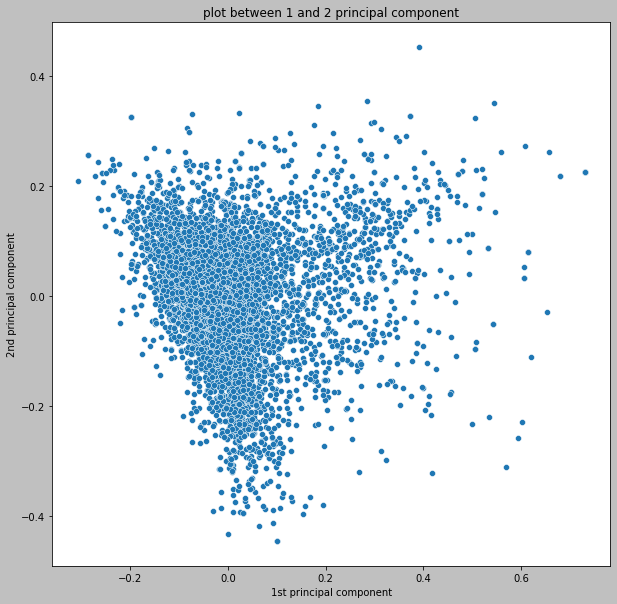

array([0.01163736, 0.00976805])

In [ ]:
pca_plot(1, 2, combined_data, 'description')

**OBSERVATION**

1. from above plot maximum variance of 1st principal component lies between [-0.2, 0.4].

2.  from above plot maximum variance of 2nd principal component lies between [-0.3, 0.2].

3. variance explained by first component is 1.16%, and by second component is 0.9%.

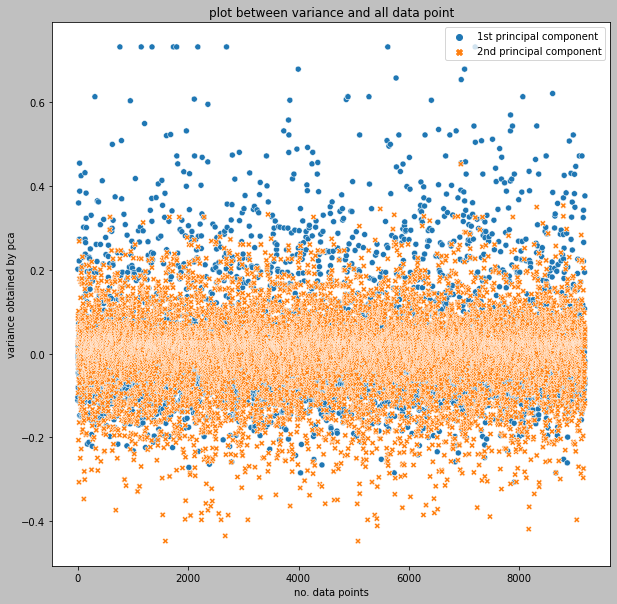

array([0.01163743, 0.00976806])

In [ ]:
pca_plot(2, 2, combined_data, 'description')

**OBSERVATION**

1. from above plot maximum variance of 1st principal component lies between [-0.2, 0.4].

2.  from above plot maximum variance of 2nd principal component lies between [-0.3, 0.2].

3. variance explained by first component is 1.16%, and by second component is 0.9%.

#### <font color='brown'>1.2.4.3 PCA ANALYSIS FOR VARIOUS PRINCIPAL COMPONENT VALUE WITH CLUSTERING</font>

In [ ]:
#https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

def find_optimal_clusters(data, rng):

  '''takes data : idf data,
              rng : max range of cluster we want to check,
          returns : cluster which have minimum sse, graphically'''

  iters = range(1, rng, 1)
  sse = []
  for k in iters:
    clus = MiniBatchKMeans(n_clusters=k, batch_size=180, random_state=42).fit(data).inertia_
    ##interia_ reponsible for sum of squared distance to its NN
    sse.append(clus)
           
  f, ax = plt.subplots(1, 1)
  f.patch.set_facecolor('silver')
  ax.plot(iters, sse, marker='o')
  ax.set_xlabel('Cluster Centers')
  ax.set_xticks(iters)
  ax.set_xticklabels(iters)
  ax.set_ylabel('SSE')
  ax.set_title('SSE by Cluster Center Plot')
plt.show()


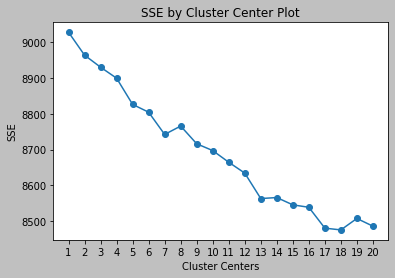

In [ ]:
_, idf, _ = tfidfvect_for_pca_plot(2, combined_data, 'description')    
find_optimal_clusters(idf, 21)

In [ ]:
def plot_cluster_label(n, frame, column):

  '''takes frame : dataframe,
      column   : text data
      n        : pca components 
      return   : labeled tranform pca visulization'''

  data, idf, _ = tfidfvect_for_pca_plot(n, frame, column)    
  clusters     = MiniBatchKMeans(n_clusters=18, batch_size=180, random_state=42).fit_predict(idf)

  labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49', 10: '#FF5733', 11: '#FDCA1B', 12: '#ABFD1B', 
    13: '#00F65D', 14: '#00BFB6', 15: '#006EBF', 16: '#0011BF', 17: '#7853B0'} 

  fig, ax = plt.subplots(figsize=(10,10))
  ax.patch.set_facecolor('silver')

  for index, instance in enumerate(data):

    pca_comp_1, pca_comp_2 = data[index]
    color = labels_color_map[clusters[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
    color = labels_color_map[clusters[index]]

  ax.legend()
  plt.title('plot of 1 and 2 pca components with cluster labels')  
  plt.xlabel('1st principal component')
  plt.ylabel('2st principal component')
  #ax.legend()
  plt.show()
  return clusters

No handles with labels found to put in legend.


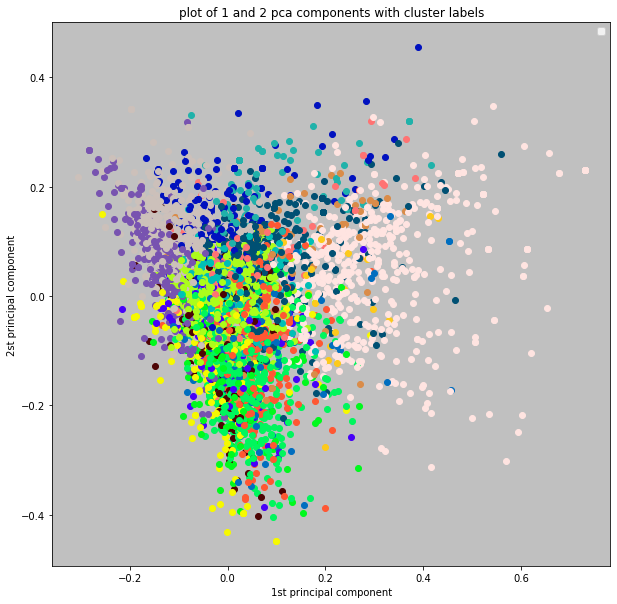

array([ 6,  3, 11, ..., 12, 17, 12], dtype=int32)

In [ ]:
plot_cluster_label(2, combined_data, 'description')

**OBSERVATION**

1. it is difficult to use linear classifier for linearly seperating pca transformed data points, it is because pca is projection of datapoints on its high variance axis but from above plot we classify purple,cyan,blue points with some misclassificaton, to check clsssifiaction among points we try for 3d plot, if we want to classify this transformed pca data we can use non linarity based models such as NN.

#### <font color='brown'>1.2.4.4 PCA ANALYSIS FOR 3 PRINCIPAL COMPONENT VALUE WITH 3D PLOT </font>

In [ ]:
def threed_cluster_plot(n, frame, column):
  data, idf, _ = tfidfvect_for_pca_plot(n,frame,column)
  clusters     = MiniBatchKMeans(n_clusters=18, batch_size=180, random_state=42).fit_predict(idf)
  df           = pd.DataFrame(data, columns=['1st component', '2nd component', '3rd component',])
  X = df['1st component']
  Y = df['2nd component']
  Z = df['3rd component']

  
  fig = px.scatter_3d(df, x= X,y =Y, z=Z, color=clusters)
  fig.update_layout(paper_bgcolor="black")
  fig.update_layout(title_text='3d pca plot')
  fig.show()

In [ ]:
threed_cluster_plot(3, combined_data, 'description')

**OBSERVATION**

1. it is difficult to use linear classifier for linearly seperating pca transformed data points, it is because pca is projection of datapoints on its high variance axis, if we want to classify this transformed pca data we can use non linarity based models such as NN.

### <font color='green'>1.3 UTILITY FUNCTION</font>

In [ ]:
def check(text, vocab):

  '''takes text : text column row  
          vocab : list of words of all grams
        returns : 1 if word from text present in vocab else 0'''

  w_t = word_tokenize(text)
  for i in w_t:
    if i in vocab:
      return 1
    else:
      return 0

In [ ]:
def ngram_check(text, n, vocab):

  '''takes text : text column row  
          vocab : list of words of all grams
              n : number of n grams to be considered
        returns : sum/count if word from text present in vocab else 0'''

  n_g = ngrams(word_tokenize(text),n)
  cnt = 0
  try:
    p = [' '.join(i) for i in n_g]
    for k in p:
      if k in vocab:
        cnt +=1
  except:
    pass
  return cnt

In [ ]:
def idf_check(x, vocab):

  '''takes x  : text column row  
        vocab : list of words of idf
      returns : 1 if word from x present in vocab else 0'''

  w_t = word_tokenize(x)
  for i in w_t:
    if i in vocab:
      return 1
    else:
      return 0

# <font color='red'>2. FEATURE ENGINEERING AND NGRAM VIZUALIZATION</font>

## <font color='blue'>2.1 PLOTTING UNI, BI, TRI, FOUR GRAM WORDCLOUD</font>

In [ ]:
from collections import Counter
def word_cloud_noun():
  word_could_dict = Counter(noun_words_list)
  fig = plt.figure(figsize=(8,8))
  fig.patch.set_facecolor('silver')
  wordcloud = WordCloud(background_color = 'black', width = 600, height = 600,
                          stopwords = stopwords, contour_width=2).generate_from_frequencies(word_could_dict)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(f'word cloud for noun words')

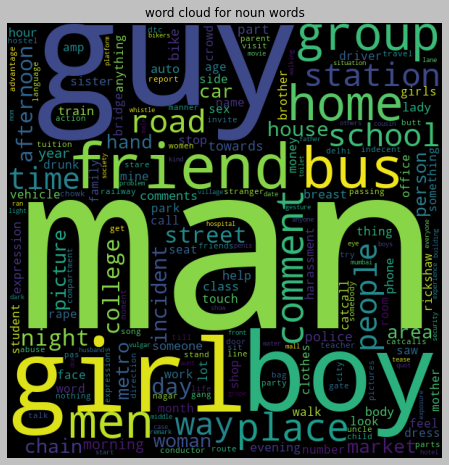

In [ ]:
word_cloud_noun()

In [ ]:
#https://stackoverflow.com/questions/49537474/wordcloud-of-bigram-using-python
#https://www.voicesofyouth.org/sites/voy/files/images/2019-02/metoo_0.jpg

from PIL import Image
from wordcloud import ImageColorGenerator

stop_wordss = list(set(stopwords.words('english')))
def n_gram_cloud(data, gram, top_feat):

  '''takes data : text column
           gram : no. of grams we want
       top_feat : no. of feature to consider for construtuing gram
       this calculates 1,2,3,4 grams'''
  
  uni  = []
  bi   = []
  tri  = []
  four = []

  for i in gram:
    vect = CountVectorizer(ngram_range=(i,i), stop_words=stop_wordss)
    bow  = vect.fit_transform(data)
    word_count = bow.sum(axis=0)                                                     ##columnwise, ives csr matrix
    word_frq   = [(word, word_count[0, k]) for word, k in vect.vocabulary_.items()]  ##csr matrxi give word and its value r,c, value
    word_frq   = sorted(word_frq, key = lambda x : x[1], reverse=True)
    word_frq   = word_frq[:top_feat]                                                 ##capturing to feature

    
    if i == 1:
      for j in range(len(word_frq)):
        uni.append(word_frq[j][0])
    elif i == 2:
      for j in range(len(word_frq)):
        bi.append(word_frq[j][0])
    elif i == 3:
      for j in range(len(word_frq)):
        tri.append(word_frq[j][0])
    else:
      for j in range(len(word_frq)):
        four.append(word_frq[j][0])

    n_word = {i[0].replace(' ', '_') : i[1] for i in word_frq}

    fig = plt.figure(figsize=(15,15))
    fig.patch.set_facecolor('silver')

    mt = np.array(Image.open('/content/gdrive/MyDrive/cs1/mt_4.jpg'))
    
    wordcloud = WordCloud(background_color = 'black', width = 600, height = 600, mask=mt,
                          stopwords = stopwords, contour_width=2).generate_from_frequencies(n_word)

    
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'{i} gram Words \n')
    plt.show()
    

    print(' ')

  return uni, bi, tri, four

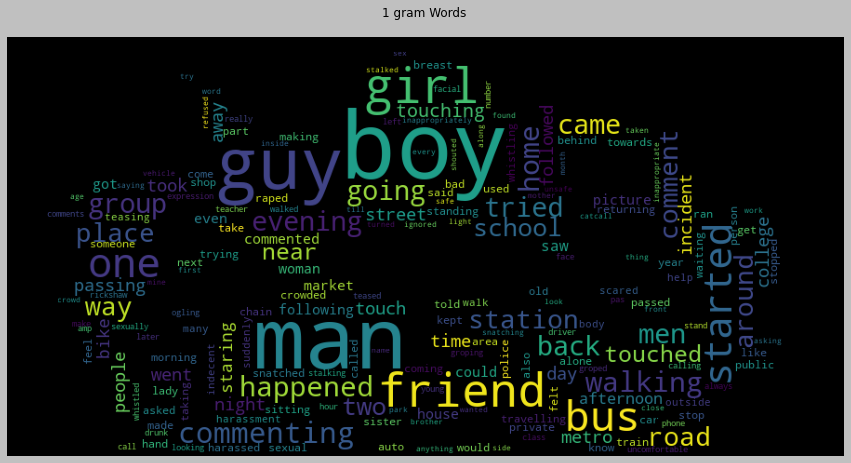

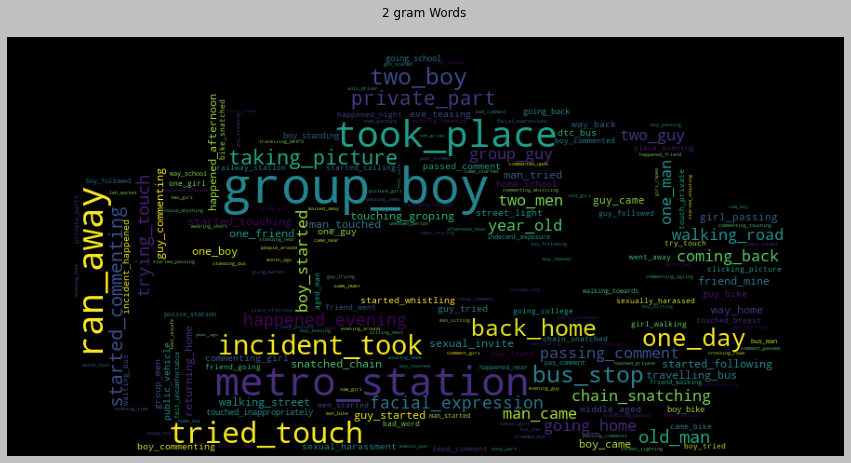

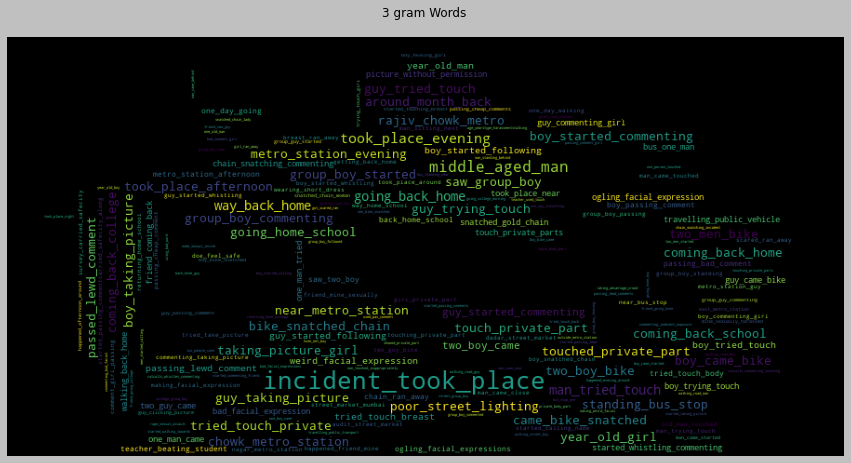

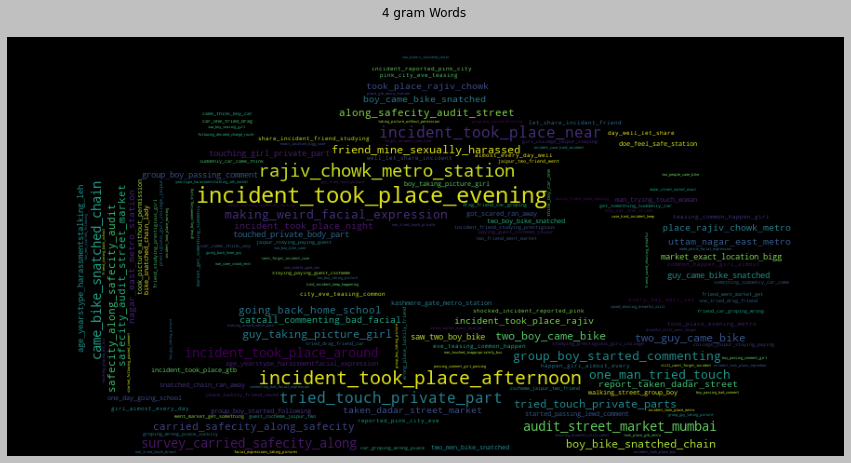

In [ ]:
uni, bi, tri, four = n_gram_cloud(combined_data["description"], [1,2,3,4], 1000)

**OBSERVATIONS**

1. as we move towards more bigram we are getting the sense of place, time, condition, in which incidence took place.

2. we are getting much more context around harassment incident such as "way_back_home" tri-gram suggest that the incident may be took when person wayback to home, "near_metro_station", "incident_took_place_evening" also give us the context around which sexual harrasment is prevalent.

In [ ]:
short_vocab = list(set(uni+bi+tri+four))

In [ ]:
def voc_for_present(vo):
  v = [i.split() for i in vo]
  K = [word for lis in v for word in lis]
  
  return list(set(K))

vocab_present_or_not = voc_for_present(short_vocab)

In [ ]:
def idf_rare_feq_word(frame, text_col, feat):   

  '''takes frame : dataframe, 
     text column : text column, 
     feature : int(max. which we want to display)
     returns : frequent, rare words based on idf value
  '''

  tfidf_vect = TfidfVectorizer(stop_words=set(stopwords.words('english')))
  idf        = tfidf_vect.fit_transform(frame[text_col])
  feat_names = tfidf_vect.get_feature_names()
  idf_value  = tfidf_vect.idf_
  df         = pd.DataFrame(list(zip(feat_names, idf_value)), columns=['word','idf_value'])

  df.sort_values("idf_value", axis = 0, ascending = False, inplace = True, ignore_index=True) #0=row

  print('| rare words with idf value |')
  print('-'*29)
  print(df.head(5))
  rare = df['word'][:feat].tolist()
  
  print('-'*29)
  print('| freq words with idf value |')
  print('-'*29)
  df.sort_values("idf_value", axis = 0, ascending = True, inplace = True, ignore_index=True)
  print(df.head(5))
  frequent     = df['word'][:feat].tolist()

  return frequent, rare

In [ ]:
idf_low, idf_high = idf_rare_feq_word(combined_data, 'description', 1000)

| rare words with idf value |
-----------------------------
         word  idf_value
0      laoded   9.433377
1     reasons   9.433377
2       hallo   9.433377
3      recess   9.433377
4  halfasleep   9.433377
-----------------------------
| freq words with idf value |
-----------------------------
     word  idf_value
0     boy   2.710747
1     guy   2.851352
2     man   2.883011
3    girl   3.035614
4  friend   3.099209


## <font color='blue'>2.2 FINAL DATAFRAME AFTER FE</font>

In [ ]:
def feature_engineering(data, column):

  '''takes data : dataframe[column]'''

  data['p_or_a'] = data[column].map(lambda x : check(x, vocab_present_or_not))
  data['4gm']    = data[column].map(lambda x : ngram_check(x,4, short_vocab))
  data['3gm']    = data[column].map(lambda x : ngram_check(x,3, short_vocab))
  data['2gm']    = data[column].map(lambda x : ngram_check(x,2, short_vocab))
  data['1gm']    = data[column].map(lambda x : ngram_check(x,1, short_vocab))

  data['idf_freqently'] = data[column].map(lambda x : idf_check(x, idf_low))  #rare low
  ##for high idf indicates less frequent word, or rarely occuring
  ##for low idf indicates more frequent word , or fequently occuring
  data['idf_rare'] = data[column].map(lambda x : idf_check(x, idf_high))      #frequent high

  data['1_2_3_4gm'] = data['4gm'] + data['3gm'] + data['2gm'] + data['1gm']
  data.drop(['4gm','3gm', '2gm', '1gm'], axis=1, inplace=True)

  data['description_len'] = data[column].astype(str).apply(len)              # length of the text
  data['word_count'] = data[column].apply(lambda x: len(str(x).split()))     # count of words 
  data['word_density'] = data['description_len'] / (data['word_count']+1)    # density of description
  
  if data.isnull().any().sum() == 0:
    pass
  else:
    data.dropna(inplace=True)

  data[['p_or_a',	'idf_freqently',	'idf_rare']].astype(int)
  data.reset_index(inplace=True, drop=True)

  return data

In [ ]:
combined_data_fe = feature_engineering(combined_data, 'description')

In [ ]:
combined_data_fe

description  ...  word_density
0     walking along crowded street holding mum hand ...  ...      5.611111
1     incident took place evening metro two guy star...  ...      5.700000
2     waiting bus man came bike offering liftvto you...  ...      5.400000
3                        incident happened inside train  ...      6.000000
4     witnessed incident chain brutally snatched eld...  ...      6.916667
...                                                 ...  ...           ...
9188                            obscene comment staring  ...      5.750000
9189  going friend metro morning group boy started c...  ...      6.400000
9190  person tried grab walkng railway station stati...  ...      6.733333
9191  bad people touched private part ranchibhagalpu...  ...      7.000000
9192        age yearstype harassment catcall leh market  ...      6.142857

[9193 rows x 14 columns]

## <font color='blue'>2.3.1 VIZUALIZING IDF_FREQUENTLY COLUMN OF FINAL DATAFRAME AFTER FE</font>

In [ ]:
def after_fe_vizualization(frame, column):
  fig = plt.figure()
  fig.patch.set_facecolor('silver')
  total = frame[column].count()
  ax = sns.countplot(x=frame[column], data=frame)
  ax.set_title("count data")
  for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.4, p.get_height()+1.4), ha='center', va='top', color='white', size=18)
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    ax.annotate(percentage, (p.get_x()+0.4, p.get_height()-1500), ha='center', size=18)

  plt.title(f'plot of unique values and its count in {column}')
  plt.xlabel(f'unique values in {column}')
  plt.ylabel(f'count of unique values in {column}')


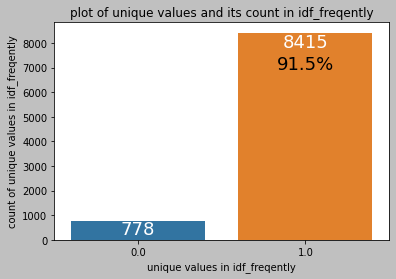

In [ ]:
after_fe_vizualization(combined_data_fe, 'idf_freqently')

**OBSERVATION**

1. in final data idf_frequently have 91.5% of 1 of all the datapoints,
which clearly indicated we have correctly taken high frequecy words (low_idf score) for frequently occuring words.

## <font color='blue'>2.3.2 VIZUALIZING IDF_RARE COLUMN OF FINAL DATAFRAME AFTER FE</font>

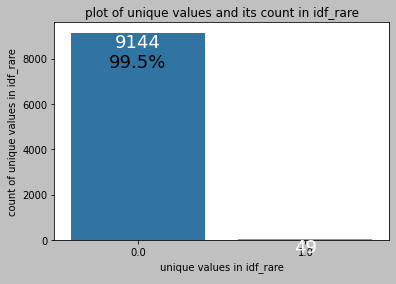

In [ ]:
after_fe_vizualization(combined_data_fe, 'idf_rare')

**OBSERVATION**

1. in final data idf_rare have 99.5% of 0 of all the datapoints,
which clearly indicated we have correctly taken low frequency words (high_idf score) for rarely occuring words.

## <font color='blue'>2.3.3 VIZUALIZING P_OR_A COLUMN OF FINAL DATAFRAME AFTER FE</font>
WORDS FROM VOCAB OF UNI, BI, TRI, FOUR GRAM PRESENT (P) OR NOT (A)

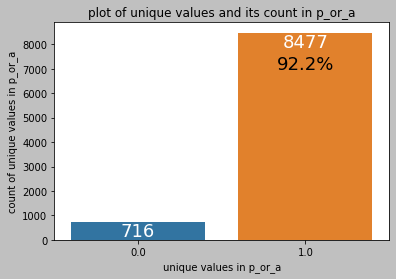

In [ ]:
after_fe_vizualization(combined_data_fe, 'p_or_a')

**OBSERVATION**

1. in final data p_or_a(present or absent) have 92.2% of 1 of all the datapoints, which is quite good as its corpus contains 4000 words from uni, bi, tri, four grams 1000 from each, it makes good proportion in overall data.

In [ ]:
import pickle
#pickle.dump((combined_data_fe), open('/content/gdrive/MyDrive/cs1/combined_data_fe4.pkl','wb'))
#combined_data_fe = pickle.load(open('/content/gdrive/MyDrive/cs1/combined_data_fe.pkl', 'rb'))

# <font color='red'>3. METRIC</font>

1. from section 1.2.2 we can see there is lot of imbalance in label data, so i would consider micro f1 score as primary metric, as it captures tp, fn, fp, of data so tells the details of each label in dataset, apart from that i will also use exact match ratio, hamming loss, micro-precision and micro-recall as secondary metric.

#REFERENCES

1. geeksforgeeks
2. [barplot percentage](https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn)
3. [ngram](https://stackoverflow.com/questions/45190708/creating-n-grams-word-cloud-using-python)
4. it is groping actully but i have used grouping.